## 라이브러리

In [1]:
import os
import time
import copy
import random
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt

import dgl
import torch
import torch_sparse
import torch.nn.functional as F

from torch import nn
from torch import Tensor
from torch.nn import Linear
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
from dgl.nn.pytorch import GraphConv
from sklearn.metrics import mean_squared_error

from typing import Optional, Tuple
from torch_sparse import SparseTensor, matmul
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\user\anaconda3\envs\fair-gnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 모델

In [22]:
def quantile_loss(y_true, y_pred, tau=0.9):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

class MYPlainGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # 단일 회귀 출력

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.fc(x).squeeze(-1)  # [N] 형태
        return out

class MYFairGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, lambda_fair=1.0):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.lambda_fair = lambda_fair

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds

    def fairness_loss(self, preds, sensitive):
        group0 = preds[sensitive == 0]
        group1 = preds[sensitive == 1]
        if len(group0) == 0 or len(group1) == 0:
            return torch.tensor(0.0, device=preds.device)
        return torch.abs(group0.mean() - group1.mean())

    def total_loss(self, preds, y_true, sensitive, tau=0.9):
        # 기본 quantile loss
        error = y_true - preds
        quantile_loss = torch.mean(torch.max(tau * error, (tau - 1) * error))

        # 공정성 정규화
        fair_loss = self.fairness_loss(preds, sensitive)

        return quantile_loss + self.lambda_fair * fair_loss

In [ ]:
# FairGNN
class GCN_Body(nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout):
        super(GCN_Body, self).__init__()
        self.gc1 = GCNConv(in_channels, hidden_channels)
        self.gc2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.gc1(x, edge_index))
        x = self.dropout(x)
        x = self.gc2(x, edge_index)
        return x

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GCN, self).__init__()
        self.body = GCN_Body(in_channels, hidden_channels, dropout)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.body(x, edge_index)
        x = self.fc(x)
        return x
    
class GAT_body(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT_body, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = F.elu
        self.gat_layers.append(GATConv(
            in_dim, num_hidden, heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        
        # hidden layers
        for l in range(1, num_layers):
            self.gat_layers.append(GATConv(
                num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, negative_slope, residual, self.activation))
            
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden * heads[-2], num_hidden, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))
        
    def forward(self, g, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](g, h).flatten(1)
        
        # output projection
        logits = self.gat_layers[-1](g, h).mean(1)

        return logits

class GAT(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT, self).__init__()

        self.body = GAT_body(num_layers, in_dim, num_hidden, heads, feat_drop, attn_drop, negative_slope, residual)
        self.fc = nn.Linear(num_hidden,num_classes)
    
    def forward(self, g, inputs):

        logits = self.body(g,inputs)
        logits = self.fc(logits)

        return logits

def get_model(model, nfeat, num_hidden=64, dropout=0.5, num_heads=1, num_layers=1, num_out_heads=1, attn_drop=0.0, negative_slope=0.2, residual=False):
    if model == "GCN":
        model = GCN_Body(nfeat, num_hidden, dropout)
    elif model == "GAT":
        heads = ([num_heads] * num_layers) + [num_out_heads]
        model = GAT_body(num_layers, nfeat, num_hidden, heads,
                         dropout, attn_drop, negative_slope, residual)
    else:
        raise ValueError("Model not implemented")
    return model

class FairGNN_Q_bf(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, model='GCN', dropout=0.5, hidden = 128, lr=0.001, weight=1e-5, tau=0.9):
        super(FairGNN_Q, self).__init__()
        
        nfeat = in_dim
        nhid = hidden_dim
        self.estimator = GCN(nfeat, hidden, 1, dropout)
        self.GNN = get_model(model, nfeat)
        self.classifier = nn.Linear(nhid, 1)
        self.adv = nn.Linear(nhid, 1)

        G_params = list(self.GNN.parameters()) + list(self.classifier.parameters()) + list(self.estimator.parameters())
        self.optimizer_G = torch.optim.Adam(G_params, lr=lr, weight_decay=weight)
        self.optimizer_A = torch.optim.Adam(self.adv.parameters(), lr=lr, weight_decay=weight)

        self.tau = tau  # Quantile 설정
        self.G_loss = 0
        self.A_loss = 0

        self.alpha = 4
        self.beta = 0.01

    def forward(self, g, x):
        s = self.estimator(g, x)
        z = self.GNN(g, x)
        y = self.classifier(z)
        return y, s

    def optimize(self, g, x, labels, idx_train, sens, idx_sens_train, tau):
        self.train()

        ### update GNN and Classifier
        self.adv.requires_grad_(False)
        self.optimizer_G.zero_grad()

        s = self.estimator(g, x)
        h = self.GNN(g, x)
        y = self.classifier(h)

        s_g = self.adv(h)

        s_score = s.detach()
        s_score[idx_sens_train] = sens[idx_sens_train].unsqueeze(1).float()

        error = labels[idx_train].unsqueeze(1).float() - y[idx_train]
        self.cls_loss = torch.mean(torch.max(tau * error, (tau - 1) * error))
        
        self.adv_loss = F.mse_loss(s_g, s_score)  # adversary는 MSE

        # 공정성 페널티
        cov = torch.abs(torch.mean((s_score - torch.mean(s_score)) * (y - torch.mean(y))))

        self.G_loss = self.cls_loss + self.alpha * cov - self.beta * self.adv_loss

        self.G_loss.backward()
        self.optimizer_G.step()

        ### update Adversary
        self.adv.requires_grad_(True)
        self.optimizer_A.zero_grad()
        s_g = self.adv(h.detach())
        self.A_loss = F.mse_loss(s_g, s_score)

        self.A_loss.backward()
        self.optimizer_A.step()

class FairGNN_Q(nn.Module):
    def __init__(self, in_dim, 
                 hidden_dim=64, dropout=0.5, hidden=128, lr=0.001, weight=1e-5, tau=0.9):
        super(FairGNN_Q, self).__init__()
        self.estimator = GCN(in_dim, hidden, 1, dropout)
        self.GNN = GCN(in_dim, hidden_dim, hidden_dim, dropout)
        self.classifier = nn.Linear(hidden_dim, 1)
        self.adv = nn.Linear(hidden_dim, 1)

        G_params = list(self.GNN.parameters()) + list(self.classifier.parameters()) + list(self.estimator.parameters())
        self.optimizer_G = torch.optim.Adam(G_params, lr=lr, weight_decay=weight)
        self.optimizer_A = torch.optim.Adam(self.adv.parameters(), lr=lr, weight_decay=weight)

        self.tau = tau
        self.G_loss = 0
        self.A_loss = 0

        self.alpha = 4
        self.beta = 0.01

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        s = self.estimator(x, edge_index)
        z = self.GNN(x, edge_index)
        y = self.classifier(z)
        return y, s

    def optimize(self, data, tau):
        x, edge_index = data.x, data.edge_index
        labels = data.y
        idx_train = data.idx_train
        sens = data.sensitive_attr
        idx_sens_train = data.idx_sens_train

        self.train()
        self.adv.requires_grad_(False)
        self.optimizer_G.zero_grad()

        s = self.estimator(x, edge_index)
        h = self.GNN(x, edge_index)
        y = self.classifier(h)

        s_g = self.adv(h)

        s_score = s.detach()
        s_score[idx_sens_train] = sens[idx_sens_train].unsqueeze(1).float()

        error = labels[idx_train].unsqueeze(1).float() - y[idx_train]
        self.cls_loss = torch.mean(torch.max(tau * error, (tau - 1) * error))

        self.adv_loss = F.mse_loss(s_g, s_score)
        cov = torch.abs(torch.mean((s_score - s_score.mean()) * (y - y.mean())))

        self.G_loss = self.cls_loss + self.alpha * cov - self.beta * self.adv_loss
        self.G_loss.backward()
        self.optimizer_G.step()

        self.adv.requires_grad_(True)
        self.optimizer_A.zero_grad()
        s_g = self.adv(h.detach())
        self.A_loss = F.mse_loss(s_g, s_score)
        self.A_loss.backward()
        self.optimizer_A.step()


In [24]:
# FMP
def get_sen(sens, idx_sens_train):
    sens_zeros = torch.zeros_like(sens)
    sens_1 = sens 
    sens_0 = (1 - sens) 
    
    sens_1[idx_sens_train] = sens_1[idx_sens_train] / len(sens_1[idx_sens_train])
    sens_0[idx_sens_train] = sens_0[idx_sens_train] / len(sens_0[idx_sens_train])

    sens_zeros[idx_sens_train] = sens_1[idx_sens_train] - sens_0[idx_sens_train]
    sen_mat = torch.unsqueeze(sens_zeros, dim=0)
    return sen_mat

def check_sen(edge_index, sen):
    nnz = edge_index.nnz()
    deg = torch.eye(edge_index.sizes()[0]).cuda()
    adj = edge_index.to_dense()
    lap = (sen.t() @ sen).to_dense()
    lap2 = deg - adj
    diff = torch.sum(torch.abs(lap2-lap)) / nnz
    assert diff < 0.000001, f'error: {diff} need to make sure L=B^TB'

class FMP_bf(GraphConv):
    r"""Fair message passing layer
    """
    _cached_sen = Optional[SparseTensor]

    def __init__(self, 
                 in_feats: int,
                 out_feats: int,
                 K: int, 
                 lambda1: float = None,
                 lambda2: float = None,
                 L2: bool = True,
                 dropout: float = 0.,
                 cached: bool = False):

        super(FMP, self).__init__(in_feats, out_feats)

        self.K = K
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.L2 = L2
        self.dropout = dropout
        self.cached = cached
        self._cached_sen = None  ## sensitive matrix
        self.propa = GraphConv(in_feats, in_feats, weight=False, bias=False, activation=None)

    def reset_parameters(self):
        self._cached_sen = None

    def forward(self, x: Tensor, 
                g, 
                idx_sens_train,
                edge_weight: OptTensor = None, 
                sens=None) -> Tensor:
        
        if g.device != features.device:
            g = g.to(features.device)

        if self.K <= 0: return x

        cache = self._cached_sen
        if cache is None:
            sen_mat = get_sen(sens=sens, idx_sens_train=idx_sens_train)               ## compute sensitive matrix

            if self.cached:
                self._cached_sen = sen_mat
                self.init_z = torch.zeros((sen_mat.size()[0], x.size()[-1]))
        else:
            sen_mat = self._cached_sen # N,

        hh = x
        x = self.emp_forward(g, x=x, hh=hh, sen=sen_mat, K=self.K)
        return x

    def emp_forward(self, g, x, hh, K, sen):
        lambda1 = self.lambda1
        lambda2 = self.lambda2

        gamma = 1/(1+lambda2)
        beta = 1/(2*gamma)

        for _ in range(K):

            if lambda2 > 0:
                y = gamma * hh + (1-gamma) * self.propa(g, feat=x)
            else:
                y = gamma * hh + (1-gamma) * x # y = x - gamma * (x - hh)

            if lambda1 > 0:
                z = sen @ F.softmax(y, dim=1) / (gamma * sen @ sen.t())
                
                x_bar0 = sen.t() @ z
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature

                correct = x_bar0 * x_bar1 

                coeff = torch.sum(x_bar0 * x_bar1, 1, keepdim=True)
                correct = correct - coeff * x_bar1

                x_bar = y - gamma * correct
                z_bar  = z + beta * (sen @ F.softmax(x_bar, dim=1))
                
                if self.L2:
                    z  = self.L2_projection(z_bar, lambda_=lambda1, beta=beta)
                else:
                    z  = self.L1_projection(z_bar, lambda_=lambda1)
                
                x_bar0 = sen.t() @ z
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature
                
                correct = x_bar0 * x_bar1 
                coeff = torch.sum(x_bar0 * x_bar1, 1, keepdim=True)
                correct = correct - coeff * x_bar1
                x = y - gamma * correct
            else:
                x = y # z=0

            x = F.dropout(x, p=self.dropout, training=self.training)
        return x

    def L1_projection(self, x: Tensor, lambda_):
        return torch.clamp(x, min=-lambda_, max=lambda_)
    
    def L2_projection(self, x: Tensor, lambda_, beta):
        coeff = (2*lambda_) / (2*lambda_ + beta)
        return coeff * x

    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}(K={}, lambda1={}, lambda2={}, L2={})'.format(
            self.__class__.__name__, self.K, self.lambda1, self.lambda2, self.L2)

class FMP_Q_bf(torch.nn.Module):
    def __init__(self, input_size, size, prop, num_layer):
        super(FMP_Q, self).__init__()

        self.hidden = nn.ModuleList()
        for _ in range(num_layer - 2):
            self.hidden.append(nn.Linear(size, size))

        self.first = nn.Linear(input_size, size)
        self.last = nn.Linear(size, 1) 

        self.prop = prop

    def reset_parameters(self):
        self.first.reset_parameters()
        self.last.reset_parameters()
        self.prop.reset_parameters()
        for layer in self.hidden:
            layer.reset_parameters()

    def forward(self, features, g, sens, idx_sens_train):
        x = features
        
        out = F.relu(self.first(x))
        for layer in self.hidden:
            out = F.relu(layer(out))
        
        x = self.last(out).squeeze(-1) 
        x = self.prop(x, sens=sens, g=g, idx_sens_train=idx_sens_train)
        return x

# FMP는 group-average correction 수준에 머물러 있어서, distribution-aware 메시지 패싱으로 발전시키려면 몇 가지 방향에서 개선
# 각 그룹(예: 남/여, 지역0/1)의 평균값만 계산해서 예측이 한쪽 그룹으로 치우치지 않게 고쳐줌. 근데, 평균값만 보면 그 그룹 안에서 어떤 일이 벌어지는지 모름.
class FMP(torch.nn.Module):
    def __init__(self, in_feats, out_feats, K, lambda1, lambda2, dropout=0.0, cached=False, L2=True):
        super(FMP, self).__init__()
        self.K = K   # 
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.L2 = L2
        self.dropout = dropout
        self.cached = cached
        self._cached_sen = None
        # self.propa = GCNConv(in_feats, in_feats, add_self_loops=False, normalize=True)
        
        self.propa = GCNConv(out_feats, out_feats, add_self_loops=False, normalize=True)  # 그래프 컨볼루션 레이어: self-loop 미포함, 메세지 전파시 degree로 normalization

    def forward(self, x, edge_index, idx_sens_train, sens):
        if self.K <= 0:
            return x

        if self._cached_sen is None:
            sen_mat = get_sen(sens=sens, idx_sens_train=idx_sens_train)  # 민감속성 차이 계산
            if self.cached:
                self._cached_sen = sen_mat
        else:
            sen_mat = self._cached_sen

        hh = x  # 원래 입력 저장: residual 연결용

        for _ in range(self.K): # 메세지 패싱 K 반복
            if self.lambda2 > 0:
                y = (1 / (1 + self.lambda2)) * hh + (self.lambda2 / (1 + self.lambda2)) * self.propa(x, edge_index)  # propagated 정보 + 원래 입력 비율 섞기
            else:
                y = hh   # 원래 입력

            if self.lambda1 > 0:   # 민감속성 보정 사용 여부
                # softmax 출력으로 민감속성별 representation 계산 
                # sen_mat: 민감속성 정보를 나타낸 행렬 
                # 그룹별 평균 softmax 특징 계산 
                z = sen_mat @ F.softmax(y, dim=1) / (sen_mat @ sen_mat.t() + 1e-8)
                # 그룹 평균 다시 노드로 확산
                x_bar0 = sen_mat.t() @ z
                x_bar1 = F.softmax(x_bar0, dim=1)
                
                # 그룹간 차이 계산
                # 각 노드의 그룹 평균과 자기 softmax 값 차이 계산 → global mean 빼서 보정값 추출
                correct = x_bar0 * x_bar1
                coeff = torch.sum(x_bar0 * x_bar1, dim=1, keepdim=True)
                correct = correct - coeff * x_bar1

                # 민감속성 보정 적용: 불공정성 줄임
                x = y - (1 / (1 + self.lambda2)) * correct
            else:
                x = y

            # dropout으로 overffiting 방지: 네트워크가 너무 특정 노드에 과적합되지 않도록 일부 뉴런을 무작위로 꺼주는 정규화 작업
            x = F.dropout(x, p=self.dropout, training=self.training)

        return x

class FMP_Q(torch.nn.Module):
    def __init__(self, input_size, size, prop, num_layer):
        super().__init__()
        self.first = nn.Linear(input_size, size)
        self.hidden = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layer - 2)])
        self.last = nn.Linear(size, 1)
        self.prop = prop

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        sens = data.sensitive_attr

        out = F.relu(self.first(x))
        for layer in self.hidden:
            out = F.relu(layer(out))

        # x = self.last(x).squeeze(-1)
        # x = self.prop(x, edge_index=edge_index, sens=sens, idx_sens_train=data.idx_sens_train)

        out = self.prop(out, edge_index=edge_index, sens=sens, idx_sens_train=data.idx_sens_train)

        x = self.last(out).squeeze(-1)  # shape: [N]
        return x

def fmp_model(data, num_layers=5, lambda1=3, lambda2=3, L2=True, num_hidden=64, num_gnn_layer=2):    
    prop = FMP(
        # in_feats=data.num_features,
        # out_feats=data.num_features,
        in_feats=num_hidden,  
        out_feats=num_hidden,
        K=num_layers,    # 메세지 패싱 반복 횟수
        lambda1=lambda1, # 민감속성 보정 정도
        lambda2=lambda2, # 메세지 패싱과 residual(원래 입력) mixing 비율: oversmoothing 방지
        L2=L2,           # L2 norm 프로젝션 여부
        cached=False
    )

    model = FMP_Q(
        input_size=data.num_features,
        size=num_hidden,
        prop=prop,
        num_layer=num_gnn_layer
    )

    return model


In [25]:
# Our
class DAFGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, device, lambda_fair=1.0, gamma=1.0, alpha=1.0, use_projection=True, use_fairness=True, use_lambda=True):
        
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

        self.lambda_fair = lambda_fair
        self.alpha = alpha
        self.gamma = gamma
        
        self.use_projection = use_projection
        self.use_fairness = use_fairness
        self.use_lambda = use_lambda
        
        self.device = device
        
    def forward(self, x, edge_index, return_hidden=False):
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        
        preds = self.fc(h).squeeze(-1)

        if return_hidden:
            return preds, h
        else:
            return preds
        
    def distribution_aware_fairness_loss(self, preds, sensitive, var_gap=True):
        g0 = preds[sensitive == 0]
        g1 = preds[sensitive == 1]

        if len(g0) == 0 or len(g1) == 0:
            return torch.tensor(0.0, device=preds.device)

        mean_gap = torch.abs(g0.mean() - g1.mean())
        gap = mean_gap
        
        if var_gap:
            var_gap = torch.abs(g0.var(unbiased=False) - g1.var(unbiased=False))
            gap = mean_gap + self.alpha * var_gap
        return gap

    def compute_bias_score(self, hidden, sensitive):
        g0 = hidden[sensitive == 0]
        g1 = hidden[sensitive == 1]
        bias = torch.norm(g0.mean(dim=0) - g1.mean(dim=0), p=2)
        return bias

    def adaptive_projection(self, h, bias_score):
        h_norm = h.norm(p=2, dim=1, keepdim=True) + 1e-6
        adaptive_lambda = self.lambda_fair * (1 + self.gamma * bias_score)
        scale = torch.min(torch.ones_like(h_norm), adaptive_lambda.unsqueeze(-1) / h_norm)
        return h * scale

    def hierarchical_lambda(self, epoch, max_lambda=1.0, beta=0.05):
        device = next(self.parameters()).device  # 모델 파라미터의 디바이스 확인
        return max_lambda * (1 - torch.exp(-beta * torch.tensor(epoch, dtype=torch.float32, device=device)))

    def total_loss(self, preds, hidden, sensitive, y_true, epoch, tau=0.9):
        
        loss_qr = quantile_loss(y_true, preds, tau)
        
        # Projection
        if self.use_projection:
            bias_score = self.compute_bias_score(hidden, sensitive)
            hidden = self.adaptive_projection(hidden, bias_score)
        
        # Fairness
        if self.use_fairness:
            fair_loss = self.distribution_aware_fairness_loss(preds, sensitive)  
        else:
            fair_loss =  torch.tensor(0.0, device=preds.device)

        # if self.use_lambda:
        #     lambda_fair = self.hierarchical_lambda(epoch, max_lambda=self.lambda_fair)
        # else:
        #     lambda_fair = self.lambda_fair

        return loss_qr + lambda_fair * fair_loss
    

In [231]:
# 분위수 예측은 단순히 "평균값"을 맞추는 문제가 아님
# 데이터 분포의 전체 모양을 예측하는 문제예요.
# 그래서 평균만 잘 맞춰도 되는 일반 회귀와 달리, 퍼짐, 꼬리, 극단값을 잘 잡아야 함

# 현재 FMP 같은 fairness-aware GNN은: 그룹별 평균 맞추기, softmax 평균 기반 편향 제거
# 근데 분위수 예측에서는: 그룹별로 “평균은 같지만, 분포 꼬리나 퍼짐이 완전 다를 수 있음”
# 특히 lower/upper quantile 쪽에서 bias가 많이 발생할 수 있음
# 그룹 A: 예측값 [0.2, 0.3, 0.4] → 분위수 안정적
# 그룹 B: 예측값 [0.1, 0.9, 0.9] → 분위수 불안정 (overshoot, undershoot)
# 결론: 평균 기반 보정만으로는 분위수 예측의 공정성이나 신뢰성을 확보하기 어려움

# distribution-aware 메시지 패싱이 왜 필요할까?
# 분위수 task에서는 평균, 분산, 꼬리, 범위 같은 분포 정보 전체를 이웃과 공유해야 함
# 이웃 정보 섞을 때 “나랑 비슷한 분포”에서만 강하게 섞어야 함
# 그룹 간 분위수 차이를 직접 비교·보정해야 함
# 예시) 0.9 분위수에서 그룹별 gap이 크게 벌어지면, 메시지 패싱 단계에서 upper quantile 쪽 정보를 집중적으로 보정

# 설계 아이디어
# 핵심 목표
# 분위수 예측에서 단순히 평균 예측 편향만 줄이는 것이 아니라, 분위수 예측의 공정성을 보장하고, 그룹 간 분포 형태(분산, 꼬리, 범위) 차이도 최소화한다. 메시지 패싱 단계에서 이웃 노드 정보도 𝜏 별로 신중히 전달
# 주요 설계
# 1. 분위수 메세지 패싱
# 2. 분위수 보정량(correction) 설계
# 3. 메세지 패싱 weight 조정
# 4. fairness loss 다층화

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

def get_sen_da(sens, idx_sens_train):
    num_nodes = sens.size(0)
    group_0_mask = (sens == 0)
    group_1_mask = (sens == 1)

    # idx_sens_train에서 그룹별 마스크
    train_group_0_mask = group_0_mask.clone()
    train_group_1_mask = group_1_mask.clone()
    train_group_0_mask[~idx_sens_train] = False
    train_group_1_mask[~idx_sens_train] = False

    group_0 = group_0_mask.float()
    group_1 = group_1_mask.float()

    sum_group_0 = train_group_0_mask.float().sum()
    sum_group_1 = train_group_1_mask.float().sum()
    if sum_group_0 == 0 or sum_group_1 == 0:
        raise ValueError(f"get_sen_da: One of the groups has no samples in idx_sens_train! group_0 sum: {sum_group_0}, group_1 sum: {sum_group_1}")

    group_0[idx_sens_train] /= sum_group_0
    group_1[idx_sens_train] /= sum_group_1

    sen_mat = torch.stack([group_0, group_1], dim=0)
    return sen_mat

class DAFMP(nn.Module):
    def __init__(self, in_feats, out_feats, K, dropout=0.0, cached=False):
        super(DAFMP, self).__init__()
        self.K = K
        self.dropout = dropout
        self.cached = cached
        self._cached_sen = None
        self.propa = GATConv(in_feats, out_feats, heads=1)

    def forward(self, x, edge_index, idx_sens_train, sens, tau, mean_baseline=1.0, var_baseline=1.0, range_baseline=1.0):
        if self.K <= 0:
            return x, None, None, None

        if self._cached_sen is None:
            sen_mat = get_sen_da(sens=sens, idx_sens_train=idx_sens_train)
            if self.cached:
                self._cached_sen = sen_mat
        else:
            sen_mat = self._cached_sen

        for _ in range(self.K):
            y = self.propa(x, edge_index)

            group_counts = sen_mat.sum(dim=1, keepdim=True)
            z_mean = sen_mat @ y / (sen_mat @ torch.ones_like(y))
            z_var = (sen_mat @ (y ** 2)) / (group_counts + 1e-8) - z_mean ** 2

            group0_mask = sen_mat[0].bool()
            group1_mask = sen_mat[1].bool()
            y_group0 = y[group0_mask]
            y_group1 = y[group1_mask]

            if y_group0.size(0) == 0 or y_group1.size(0) == 0:
                raise ValueError("One of the groups has no samples! Check your sens and idx_sens_train.")

            z_min0, _ = torch.min(y_group0, dim=0, keepdim=True)
            z_max0, _ = torch.max(y_group0, dim=0, keepdim=True)
            z_min1, _ = torch.min(y_group1, dim=0, keepdim=True)
            z_max1, _ = torch.max(y_group1, dim=0, keepdim=True)

            z_range0 = z_max0 - z_min0
            z_range1 = z_max1 - z_min1

            mean_gap = torch.abs(z_mean[0] - z_mean[1])
            var_gap = torch.abs(z_var[0] - z_var[1])
            range_gap = torch.abs(z_range0 - z_range1)

            mean_gap_norm = mean_gap / (mean_baseline + 1e-8)
            var_gap_norm = var_gap / (var_baseline + 1e-8)
            range_gap_norm = range_gap / (range_baseline + 1e-8)

            tau_scalar = tau.mean() if isinstance(tau, torch.Tensor) and tau.numel() > 1 else tau

            correction = tau_scalar * (mean_gap_norm + var_gap_norm + range_gap_norm)

            x = y - correction
            x = F.dropout(x, p=self.dropout, training=self.training)

        return x, mean_gap, var_gap, range_gap

class DAFGNN_2(nn.Module):
    def __init__(self, input_size, size, prop, num_layer):
        super().__init__()
        self.first = nn.Linear(input_size, size)
        self.hidden = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layer - 2)])
        self.last = nn.Linear(size, 1)
        self.prop = prop

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        sens = data.sensitive_attr
        tau = data.quantile_tau

        out = F.relu(self.first(x))
        for layer in self.hidden:
            out = F.relu(layer(out))

        # DAFMP 호출 후 tuple 언팩
        out, mean_gap, var_gap, range_gap = self.prop(
            out, edge_index=edge_index, sens=sens, idx_sens_train=data.idx_sens_train, tau=tau
        )

        x = self.last(out).squeeze(-1)
        return x, mean_gap, var_gap, range_gap

def daf_model(data, num_layers=5, num_hidden=64, num_gnn_layer=2):
    prop = DAFMP(
        in_feats=num_hidden,
        out_feats=num_hidden,
        K=num_layers,
        cached=False
    )

    model = DAFGNN_2(
        input_size=data.num_features,
        size=num_hidden,
        prop=prop,
        num_layer=num_gnn_layer
    )

    return model

def daf_loss(y_true, y_pred, tau, mean_gap, var_gap, range_gap, lambda_fair, mean_baseline=1.0, var_baseline=1.0, range_baseline=1.0):
    diff = y_true - y_pred
    qr_loss = torch.mean(torch.max(tau * diff, (tau - 1) * diff))

    mean_gap_norm = mean_gap / (mean_baseline + 1e-8)
    var_gap_norm = var_gap / (var_baseline + 1e-8)
    range_gap_norm = range_gap / (range_baseline + 1e-8)

    # Reduce to scalar
    fairness_loss = lambda_fair * (mean_gap_norm.mean() + var_gap_norm.mean() + range_gap_norm.mean())

    return qr_loss + fairness_loss


In [233]:
class DAFMP(nn.Module):
    def __init__(self, in_feats, out_feats, K, dropout=0.0, cached=False, lambda_fair=1.0, gamma=1.0, use_projection=True):
        super(DAFMP, self).__init__()
        self.K = K
        self.dropout = dropout
        self.cached = cached
        self.lambda_fair = lambda_fair
        self.gamma = gamma
        self.use_projection = use_projection
        self._cached_sen = None

        self.propa = GATConv(out_feats + 1, out_feats, heads=1)

    def compute_bias_score(self, hidden, sensitive):
        g0 = hidden[sensitive == 0]
        g1 = hidden[sensitive == 1]
        if len(g0) == 0 or len(g1) == 0:
            return torch.tensor(0.0, device=hidden.device)
        return torch.norm(g0.mean(dim=0) - g1.mean(dim=0), p=2)

    def adaptive_projection(self, h, bias_score):
        h_norm = h.norm(p=2, dim=1, keepdim=True) + 1e-6
        adaptive_lambda = self.lambda_fair * (1 + self.gamma * bias_score)
        scale = torch.min(torch.ones_like(h_norm), adaptive_lambda.unsqueeze(-1) / h_norm)
        return h * scale

    def forward(self, x, edge_index, idx_sens_train, sens, tau, mean_baseline=1.0, var_baseline=1.0, range_baseline=1.0):
        if self.K <= 0:
            return x, 0, 0, 0

        if self._cached_sen is None:
            sen_mat = get_sen(sens=sens, idx_sens_train=idx_sens_train)
            if self.cached:
                self._cached_sen = sen_mat
        else:
            sen_mat = self._cached_sen

        tau_expand = tau.unsqueeze(-1).repeat(1, x.size(1))
        x = torch.cat([x, tau_expand], dim=1)

        for _ in range(self.K):
            y = self.propa(x, edge_index)

            z_mean = sen_mat @ y / (sen_mat @ sen_mat.t() + 1e-8)
            z_var = sen_mat @ (y ** 2) / (sen_mat @ sen_mat.t() + 1e-8) - z_mean ** 2
            z_min, _ = torch.min(y, dim=0, keepdim=True)
            z_max, _ = torch.max(y, dim=0, keepdim=True)
            z_range = z_max - z_min

            mean_gap = torch.abs(z_mean[0] - z_mean[1])
            var_gap = torch.abs(z_var[0] - z_var[1])
            range_gap = torch.abs(z_range[0] - z_range[1])

            mean_gap_norm = mean_gap / (mean_baseline + 1e-8)
            var_gap_norm = var_gap / (var_baseline + 1e-8)
            range_gap_norm = range_gap / (range_baseline + 1e-8)

            correction = mean_gap_norm + var_gap_norm + range_gap_norm
            x = y - correction

            x = F.dropout(x, p=self.dropout, training=self.training)

        if self.use_projection:
            bias_score = self.compute_bias_score(x, sens)
            x = self.adaptive_projection(x, bias_score)

        return x, mean_gap, var_gap, range_gap

class DAFGNN_2(nn.Module):
    def __init__(self, input_size, size, prop, num_layer):
        super().__init__()
        self.first = nn.Linear(input_size, size)
        self.hidden = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layer - 2)])
        self.last = nn.Linear(size, 1)
        self.prop = prop

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        sens = data.sensitive_attr
        tau = data.quantile_tau

        out = F.relu(self.first(x))
        for layer in self.hidden:
            out = F.relu(layer(out))

        out, mean_gap, var_gap, range_gap = self.prop(out, edge_index=edge_index, sens=sens,
                                                      idx_sens_train=data.idx_sens_train, tau=tau)
        x = self.last(out).squeeze(-1)
        return x, mean_gap, var_gap, range_gap

def daf_loss(y_true, y_pred, tau, mean_gap, var_gap, range_gap, lambda_fair,
             mean_baseline=1.0, var_baseline=1.0, range_baseline=1.0):
    diff = y_true - y_pred
    qr_loss = torch.mean(torch.max(tau * diff, (tau - 1) * diff))

    mean_gap_norm = mean_gap / (mean_baseline + 1e-8)
    var_gap_norm = var_gap / (var_baseline + 1e-8)
    range_gap_norm = range_gap / (range_baseline + 1e-8)

    fairness_loss = lambda_fair * (mean_gap_norm + var_gap_norm + range_gap_norm)

    return qr_loss + fairness_loss

def daf_model(data, num_layers=5, num_hidden=64, num_gnn_layer=2, lambda_fair=1.0, gamma=1.0, use_projection=True):
    prop = DAFMP(
        in_feats=num_hidden,
        out_feats=num_hidden,
        K=num_layers,
        cached=False,
        lambda_fair=lambda_fair,
        gamma=gamma,
        use_projection=use_projection
    )

    model = DAFGNN_2(
        input_size=data.num_features,
        size=num_hidden,
        prop=prop,
        num_layer=num_gnn_layer
    )

    return model


## 함수

In [27]:
# 데이터 로드 
def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

def load_dataset(dataset,sens_attr,predict_attr, path="./dataset/pokec/", 
               label_number=1000, sens_number=500, test_idx=False, seed=1127):
    """Load data"""
    print('Loading {} dataset from {}'.format(dataset,path))

    idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove("user_id")

    header.remove(sens_attr)
    header.remove(predict_attr)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values
    
    # build graph
    idx = np.array(idx_features_labels["user_id"], dtype=int)
    idx_map = {j: i for i, j in enumerate(idx)}

    # edges_unordered = np.genfromtxt(os.path.join(path,"{}_relationship.txt".format(dataset)), dtype=int)
    edges_unordered = np.genfromtxt(os.path.join(path, f"{dataset}_relationship.txt"), dtype=np.int64)

    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=int).reshape(edges_unordered.shape)
    mapped_edges = []
    dropped = 0
    for u, v in edges_unordered:
        u_mapped = idx_map.get(u)
        v_mapped = idx_map.get(v)
        if u_mapped is not None and v_mapped is not None:
            mapped_edges.append((u_mapped, v_mapped))
        else:
            dropped += 1

    print(f"[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: {dropped}")
    edges = np.array(mapped_edges, dtype=int)

    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # features = normalize(features)
    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    # adj = sparse_mx_to_torch_sparse_tensor(adj)

    random.seed(seed)
    label_idx = np.where(labels>=0)[0]
    random.shuffle(label_idx)

    idx_train = label_idx[:min(int(0.5 * len(label_idx)),label_number)]
    idx_val = label_idx[int(0.5 * len(label_idx)):int(0.75 * len(label_idx))]
    if test_idx:
        idx_test = label_idx[label_number:]
        idx_val = idx_test
    else:
        idx_test = label_idx[int(0.75 * len(label_idx)):]

    sens = idx_features_labels[sens_attr].values

    sens_idx = set(np.where(sens >= 0)[0])
    idx_test = np.asarray(list(sens_idx & set(idx_test)))
    sens = torch.FloatTensor(sens)
    idx_sens_train = list(sens_idx - set(idx_val) - set(idx_test))
    random.seed(seed)
    random.shuffle(idx_sens_train)
    idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    
    # random.shuffle(sens_idx)

    return adj, features, labels, idx_train, idx_val, idx_test, sens,idx_sens_train

def is_symmetric(m):
    '''
    Judge whether the matrix is symmetric or not.
    :param m: Adjacency matrix(Array)
    '''
    res = np.int64(np.triu(m).T == np.tril(m))
    # if np.where(res==0)[0] != []:
    if np.where(res == 0)[0].size > 0:
        raise ValueError("The matrix is not symmetric!")
    else:
        pass
    
def symetric_normalize(m, half: bool):
    '''
    Symmetrically normalization for adjacency matrix
    :param m: (Array) Adjacency matrix
    :param half: (bool) whether m is triu or full
    :return: (Array) An symmetric adjacency matrix
    '''
    if not half:
        is_symmetric(m)
    else:
        m = m + m.T - np.diag(np.diagonal(m))

    hat_m = m + np.eye(m.shape[0])
    D = np.sum(hat_m, axis=1)
    D = np.diag(D)

    # D = np.power(D, -0.5)
    with np.errstate(divide='ignore'):
        D = np.power(D, -0.5)
        D[np.isinf(D)] = 0

    D[np.isinf(D)] = 0
    sn_m = np.matmul(np.matmul(D, hat_m), D)
    return sn_m

def sp2sptensor(m):
    # sparse_m = sp.coo_matrix(m).astype(np.float)
    sparse_m = sp.coo_matrix(m).astype(np.float64)
    # indices = torch.from_numpy(np.vstack((sparse_m.row, sparse_m.col)).astype(int))
    indices = torch.from_numpy(np.vstack((sparse_m.row, sparse_m.col))).long()
    values = torch.from_numpy(sparse_m.data)
    shape = torch.Size(sparse_m.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

class German:
    def __init__(self, path):
        if not os.path.exists(path):
            raise ValueError("Data path doesn't exist!")
        else:
            self.data_path = path
        self.raw_data = self._node_process()
        self.A_tensor, self.A = self._edge_process()
        self.senIdx, self.sen_vals, self.trainIdxtensor, self.valIdxTensor, self.testIdxTensor, self.features, self.labels = self._split_data()

    def _node_process(self):
        filenames = os.listdir(self.data_path)

        for file in filenames:
            if os.path.splitext(file)[1] != '.csv':
                continue
            else:
                df_data = pd.read_csv(os.path.join(self.data_path, file))

                # modify str feature
                # df_data['GoodCustomer'].replace(-1, 0, inplace=True)
                df_data['GoodCustomer'] = df_data['GoodCustomer'].replace(-1, 0).astype(int)

                # df_data['Gender'].replace('Male', 1, inplace=True)
                # df_data['Gender'].replace('Female', 0, inplace=True)
                gender_map = {'Female': 0, 'Male': 1}
                df_data['Gender'] = df_data['Gender'].map(gender_map).astype(int)

                purposeList = list(df_data['PurposeOfLoan'])
                random.shuffle(purposeList)
                purposeDict = {}
                index = 0
                for pur in purposeList:
                    if purposeDict.get(pur, None) is None:
                        purposeDict[pur] = index
                        index += 1
                    else:
                        continue

                for key in purposeDict.keys():
                    # df_data['PurposeOfLoan'].replace(key, purposeDict[key], inplace=True)
                    df_data['PurposeOfLoan'] = df_data['PurposeOfLoan'].map(purposeDict).fillna(-1).astype(int)
                    
                return df_data

    def _edge_process(self):
        filenames = os.listdir(self.data_path)

        for file in filenames:
            if os.path.splitext(file)[1] != '.txt':
                continue
            else:
                edges = np.loadtxt(os.path.join(self.data_path, file)).astype(int)

                # Adjacency
                num_dim = len(self.raw_data)
                A = np.zeros((num_dim, num_dim))
                for i in range(len(edges)):
                    A[edges[i][0]][edges[i][1]] = 1
                    A[edges[i][1]][edges[i][0]] = 1
                sym_norm_A = symetric_normalize(A, half=False)
                syn_norm_A_tensor = sp2sptensor(sym_norm_A)
                return syn_norm_A_tensor, A

    def _split_data(self):
        pos_data = self.raw_data[self.raw_data['GoodCustomer']==1]
        pos_index = list(pos_data.index)
        neg_data = self.raw_data[self.raw_data['GoodCustomer']==0]
        neg_index = list(neg_data.index)

        # shuffle the index
        random.seed(20)
        random.shuffle(pos_index)
        random.shuffle(neg_index)

        # split the data
        train_pos_idx = pos_index[:int(0.5*len(pos_index))]
        train_neg_idx = neg_index[:int(0.5*len(neg_index))]
        val_pos_idx = pos_index[int(0.5*len(pos_index)): int(0.75*len(pos_index))]
        val_neg_idx = neg_index[int(0.5*len(neg_index)): int(0.75*len(neg_index))]
        test_pos_idx = pos_index[int(0.75*len(pos_index)):]
        test_neg_idx = neg_index[int(0.75*len(neg_index)):]

        trainIdx = train_pos_idx + train_neg_idx
        random.shuffle(trainIdx)
        valIdx = val_pos_idx + val_neg_idx
        random.shuffle(valIdx)
        testIdx = test_pos_idx + test_neg_idx
        random.shuffle(testIdx)

        assert len(trainIdx)+len(valIdx)+len(testIdx) == len(self.raw_data), "Missing data or leaking data!"

        feature_cols = list(self.raw_data.columns)
        feature_cols.remove('GoodCustomer')
        sen_idx = feature_cols.index('Gender')
        sen_vals = self.raw_data['Gender'].values.astype(int)
        feature_data = self.raw_data[feature_cols]
        labels = self.raw_data['GoodCustomer']

        # transform to tensor
        trainIdxTensor = torch.LongTensor(trainIdx)
        valIdxTensor = torch.LongTensor(valIdx)
        testIdxTensor = torch.LongTensor(testIdx)
        featuredata = torch.FloatTensor(np.array(feature_data))
        labels = torch.LongTensor(np.array(labels))

        return sen_idx, sen_vals, trainIdxTensor, valIdxTensor, testIdxTensor, featuredata, labels

    def get_index(self):
        return [self.trainIdxtensor, self.valIdxTensor, self.testIdxTensor]

    def get_raw_data(self):
        return [self.features, self.A_tensor, self.labels]

    def generate_counterfactual_perturbation(self, data):
        '''
        Generate counterfactual data by flipping sensitive attribute.
        :param data: Tensor
        :return: counterfactual data
        '''
        feature_data = copy.deepcopy(data)
        feature_data[:, self.senIdx] = 1 - feature_data[:, self.senIdx]
        return feature_data

    def generate_node_perturbation(self, prob: float, sen: bool = False):
        '''
        Perturbing node attributes, except for sensitive attributes.
        :param prob: portion of perturbed data
        :return: perturbed data
        '''
        feature_data = copy.deepcopy(self.features)
        r = np.random.binomial(n=1, p=prob, size=feature_data.numpy().shape)
        for i in range(len(feature_data)):
            r[i][self.senIdx] = 0
        noise = np.multiply(r, np.random.normal(0., 1., r.shape))
        noise_tensor = torch.FloatTensor(noise)
        x_hat = feature_data + noise_tensor

        if sen:
            x_hat = self.generate_counterfactual_perturbation(x_hat)
        return x_hat

    def generate_struc_perturbation(self, drop_prob: float, tensor: bool = True):
        A = copy.deepcopy(self.A)
        half_A = np.triu(A)
        row, col = np.nonzero(half_A)
        idx_perturb = np.random.binomial(n=1, p=1-drop_prob, size=row.shape)
        broken_edges = np.where(idx_perturb==0)[0]
        for idx in broken_edges:
            half_A[row[idx]][col[idx]] = 0
        new_A = symetric_normalize(half_A, half=True)
        if tensor:
            new_A = sp2sptensor(new_A)
        return new_A

def load_dataset_unified(dataset, sens_attr, predict_attr, path="./dataset/", 
                         label_number=1000, sens_number=500, test_idx=False, seed=1127):
    if dataset.lower() != 'german':
        full_path = path
        # full_path = os.path.join(path, "pokec")
        return load_dataset(dataset, sens_attr, predict_attr, full_path, label_number, sens_number, test_idx, seed)

    elif dataset.lower() == 'german':
        full_path = path
        # full_path = os.path.join(path, "german")
        german_data = German(full_path)

        adj = german_data.A_tensor
        features = german_data.features
        labels = german_data.labels
        sens = torch.FloatTensor(german_data.sen_vals)
        idx_train, idx_val, idx_test = german_data.get_index()

        # 민감 속성 학습용 인덱스 (val/test 제외)
        all_idx = set(range(len(sens)))
        sens_idx = set(np.where(sens.numpy() >= 0)[0])
        idx_sens_train = list(sens_idx - set(idx_val.numpy()) - set(idx_test.numpy()))
        random.seed(seed)
        random.shuffle(idx_sens_train)
        idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

        return adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train

    else:
        raise ValueError(f"Unsupported dataset: {dataset}")


In [ ]:
# 평가 함수
def evaluate(model, data, idx_eval, tau=0.9):
    model.eval()
    if isinstance(model, DAFGNN):
        preds = model(data.x, data.edge_index, return_hidden=False)
    elif isinstance(model, DAFGNN_2):
        preds = model(data)
    elif isinstance(model, MYFairGNN):
        preds = model(data.x, data.edge_index)
    elif isinstance(model, MYPlainGNN):
        preds = model(data.x, data.edge_index)
    elif isinstance(model, FairGNN_Q):
        preds, _ = model(data)
    elif isinstance(model, FMP_Q):
        preds = model(data)
        
    preds_eval = preds[idx_eval]
    sens_eval = data.sensitive_attr[idx_eval]
    
    g0 = preds_eval[sens_eval == 0]
    g1 = preds_eval[sens_eval == 1]
    
    if len(g0) == 0 or len(g1) == 0:
        fair_loss = None
    else:
        fair_loss = torch.abs(g0.mean() - g1.mean()).item()
        
    qr_loss = quantile_loss(data.y[idx_eval], preds_eval, tau).item()
    return qr_loss, fair_loss

def evaluate_metrics(model, data, idx_eval, tau=0.9):
    model.eval()

    if isinstance(model, DAFGNN):
        preds, _ = model(data.x, data.edge_index, return_hidden=True)
    elif isinstance(model, MYFairGNN):
        preds = model(data.x, data.edge_index)
    elif isinstance(model, MYPlainGNN):
        preds = model(data.x, data.edge_index)
    elif isinstance(model, FairGNN_Q):
        preds, _ = model(data)
    elif isinstance(model, FMP_Q):
        preds = model(data)
    elif isinstance(model, DAFGNN_2):
        preds = model(data)

    preds = preds[idx_eval].cpu()
    y_true = data.y[idx_eval].cpu()
    sensitive = data.sensitive_attr[idx_eval].cpu()

    error = y_true - preds
    qr_loss = torch.mean(torch.max(tau * error, (tau - 1) * error)).item()
    mae = torch.mean(torch.abs(error)).item()
    rmse = torch.sqrt(torch.mean(error ** 2)).item()
    r2 = 1 - torch.sum(error ** 2) / torch.sum((y_true - y_true.mean()) ** 2)

    group0 = preds[sensitive == 0]
    group1 = preds[sensitive == 1]
    fair_gap = torch.abs(group0.mean() - group1.mean()).item()

    results = {
        'QR Loss': qr_loss,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2.item(),
        'Fairness Gap': fair_gap
    }

    return results

def our_groupwise_evaluation(model, data, idx_eval, tau=0.9):
    model.eval()

    preds, _ = model(data.x, data.edge_index, return_hidden=True)

    preds = preds[idx_eval]
    y_true = data.y[idx_eval]
    sensitive = data.sensitive_attr[idx_eval]

    # 전체 QR loss
    overall_qr = quantile_loss(y_true, preds, tau).item()

    # Group별 나누기
    preds_g0 = preds[sensitive == 0]
    preds_g1 = preds[sensitive == 1]
    y_true_g0 = y_true[sensitive == 0]
    y_true_g1 = y_true[sensitive == 1]

    # Group별 QR loss
    qr_loss_g0 = quantile_loss(y_true_g0, preds_g0, tau).item()
    qr_loss_g1 = quantile_loss(y_true_g1, preds_g1, tau).item()

    # Group별 예측 평균 (Fairness 측정용)
    mean_pred_g0 = preds_g0.mean().item()
    mean_pred_g1 = preds_g1.mean().item()
    fairness_gap = abs(mean_pred_g0 - mean_pred_g1)

    results = {
        'Overall QR Loss': overall_qr,
        'Group 0 QR Loss': qr_loss_g0,
        'Group 1 QR Loss': qr_loss_g1,
        'Fairness Gap (mean)': fairness_gap,
    }

    return results

def regression_evaluation_metrics(model, data, idx_eval, tau=0.9):
    model.eval()

    # 예측
    if isinstance(model, DAFGNN):
        preds, _ = model(data.x, data.edge_index, return_hidden=True)
    elif isinstance(model, (MYFairGNN, MYPlainGNN)):
        preds = model(data.x, data.edge_index)
    elif isinstance(model, FairGNN_Q):
        preds, _ = model(data)
    elif isinstance(model, FMP_Q):
        preds = model(data)
    elif isinstance(model, DAFGNN_2):
        preds_tuple = model(data)
        if isinstance(preds_tuple, tuple):
            preds = preds_tuple[0]
        else:
            preds = preds_tuple

    # Tensor → numpy
    y_pred = preds[idx_eval].detach().cpu().numpy().flatten()
    y_true = data.y[idx_eval].detach().cpu().numpy().flatten()
    sensitive_attr = data.sensitive_attr[idx_eval].detach().cpu().numpy().flatten()

    # 기본 오류 계산
    error = y_true - y_pred
    abs_error = np.abs(error)
    sq_error = error ** 2

    # MAPE 관련 계산 시 y_true가 너무 작으면 제거
    mask = np.abs(y_true) > 1e-4
    mape_safe = abs_error[mask] / (np.abs(y_true[mask]) + 1e-8)
    mape = np.mean(mape_safe)
    mape_var = np.var(mape_safe)

    # QR Loss
    error_torch = torch.tensor(error)
    qr_loss = torch.mean(torch.max(tau * error_torch, (tau - 1) * error_torch)).item()

    # 정확도
    mae = np.mean(abs_error)
    rmse = np.sqrt(np.mean(sq_error))
    mae_var = np.var(abs_error)
    r2 = 1 - np.sum(sq_error) / np.sum((y_true - y_true.mean()) ** 2)

    # 그룹별
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'group': sensitive_attr
    })

    group_metrics = {}
    for group_id in np.unique(sensitive_attr):
        group = df[df['group'] == group_id]
        g_m = np.mean(group['y_pred'])
        g_err = np.abs(group['y_true'] - group['y_pred'])
        g_sq = (group['y_true'] - group['y_pred']) ** 2

        group_metrics[f'mean_group_{int(group_id)}'] = g_m
        group_metrics[f'mae_group_{int(group_id)}'] = g_err.mean()
        group_metrics[f'rmse_group_{int(group_id)}'] = np.sqrt(g_sq.mean())

    mean_gap = abs(group_metrics.get('mean_group_0', 0) - group_metrics.get('mean_group_1', 0))
    mae_gap = abs(group_metrics.get('mae_group_0', 0) - group_metrics.get('mae_group_1', 0))
    rmse_gap = abs(group_metrics.get('rmse_group_0', 0) - group_metrics.get('rmse_group_1', 0))

    # 민감속성과 오차의 상관관계
    corr_error = np.corrcoef(abs_error, sensitive_attr)[0, 1]    

    return {
        'QR Loss': qr_loss,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2,
        'MAE-Var': mae_var,
        'MAPE-Var': mape_var,
        'Mean Gap': mean_gap,
        'MAE Gap': mae_gap,
        'RMSE Gap': rmse_gap,
        'Error-Sensitive Corr': corr_error,
        **group_metrics
    }

def generate_latex_rows(df, metric_names, end_column=' \\\\'):
    latex_lines = []
    for idx, row in df.iterrows():
        model = row['Model']
        line = f"& {model}"
        for metric in metric_names:
            mean = row[f"{metric} Mean"]
            std = row[f"{metric} Std"]
            line += f" & ${mean:.2f} \\pm {std:.2f}$"
        line += f" {end_column} \\\\"
        latex_lines.append(line)
    return latex_lines


In [29]:
# 모델 학습
def train_model(model_class, data, device, tau=0.9, lambda_fair=1.0, hidden_dim=64, n_epochs=500, lr=0.01, weight=5e-4):
    in_dim = data.x.size(1)
    if model_class.__name__ == 'DAFGNN':
        model = model_class(in_dim, hidden_dim, device, lambda_fair).to(device)
    elif model_class.__name__ == 'MYFairGNN':
        model = model_class(in_dim, hidden_dim, lambda_fair).to(device)
    elif model_class.__name__ == 'MYPlainGNN':
        model = model_class(in_dim, hidden_dim).to(device)
    elif model_class.__name__ == 'FairGNN_Q':
        model = model_class(in_dim, hidden_dim, tau).to(device)
    elif model_class.__name__ == 'FMP_Q':
        model = fmp_model(data).to(device)
    elif model_class.__name__ == 'DAFGNN_2':
        model = daf_model(data).to(device)

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight)

    data = data.to(device)
    data.sensitive_attr = data.sensitive_attr.to(device)
    
    print('-' * 100)
    n_epochs = int(n_epochs)
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()

        if isinstance(model, DAFGNN):
            preds, hidden = model(data.x, data.edge_index, return_hidden=True)
            loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
            loss.backward()
            optimizer.step()
        elif isinstance(model, MYFairGNN):
            preds = model(data.x, data.edge_index)
            loss = model.total_loss(preds[data.idx_train], data.y[data.idx_train], data.sensitive_attr[data.idx_train], tau)
            loss.backward()
            optimizer.step()
        elif isinstance(model, MYPlainGNN):
            preds = model(data.x, data.edge_index)
            loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)
            loss.backward()
            optimizer.step()
        elif isinstance(model, FairGNN_Q):
            model.optimize(data, tau)
            loss = model.G_loss 
        elif isinstance(model, FMP_Q):
            preds = model(data)
            loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)
            loss.backward()
            optimizer.step()
        elif isinstance(model, DAFGNN_2):
            preds, mean_gap, var_gap, range_gap = model(data)
            loss = daf_loss(data.y[data.idx_train], preds[data.idx_train], tau, mean_gap, var_gap, range_gap, lambda_fair)
            loss.backward()
            optimizer.step()
            
        if epoch % 100 == 0 or epoch == 1:
            print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")
            
    return model

def train_one_epoch(model, data, optimizer, epoch, tau=0.9):
    model.train()
    optimizer.zero_grad()

    if isinstance(model, DAFGNN):
        preds, hidden = model(data.x, data.edge_index, return_hidden=True)
        loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
        loss.backward()
        optimizer.step()
    elif isinstance(model, MYFairGNN):
        preds = model(data.x, data.edge_index)
        loss = model.total_loss(preds[data.idx_train], data.y[data.idx_train], data.sensitive_attr[data.idx_train], tau)
        loss.backward()
        optimizer.step()
    elif isinstance(model, MYPlainGNN):
        preds = model(data.x, data.edge_index)
        loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)
        loss.backward()
        optimizer.step()
    elif isinstance(model, FairGNN_Q):
        model.optimize(data, tau)
        loss = model.G_loss 
    elif isinstance(model, FMP_Q):
        preds = model(data)
        loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)
        loss.backward()
        optimizer.step()
    elif isinstance(model, DAFGNN_2):
        preds, mean_gap, var_gap, range_gap = model(data)
        loss = daf_loss(data.y[data.idx_train], preds[data.idx_train], tau, mean_gap, var_gap, range_gap, lambda_fair)
        loss.backward()
        optimizer.step()
            
    return loss.item()

def run_experiment(model_class, data, device, tau=0.9, lambda_fair=1.0, hidden_dim=64, n_epochs=500, lr=0.01, weight=5e-4):
    print(device)
    in_dim = data.x.size(1)
    
    if model_class.__name__ == 'DAFGNN':
        model = model_class(in_dim, hidden_dim, device, lambda_fair).to(device)
    elif model_class.__name__ == 'MYFairGNN':
        model = model_class(in_dim, hidden_dim, lambda_fair).to(device)
    elif model_class.__name__ == 'MYPlainGNN':
        model = model_class(in_dim, hidden_dim).to(device)
    elif model_class.__name__ == 'FairGNN_Q':
        model = model_class(in_dim, hidden_dim).to(device)
    elif model_class.__name__ == 'FMP_Q':
        model = fmp_model(data).to(device)
    elif model_class.__name__ == 'DAFGNN_2':
        model = daf_loss(data).to(device)

    data = data.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight)

    best_val_qr = float('inf')
    best_model = None
    
    print('-' * 100)
    for epoch in range(1, n_epochs + 1):
        train_one_epoch(model, data, optimizer, epoch, tau=tau)
        val_qr, val_fair = evaluate(model, data, data.idx_val, tau=tau)
        
        if val_qr < best_val_qr:
            best_val_qr = val_qr
            best_model = model.state_dict()

        if epoch % 100 == 0 or epoch == n_epochs:
            print(f"[{model_class.__name__}] Epoch {epoch}: Val QR Loss={val_qr:.4f}, Fairness Gap={val_fair:.4f}")
            
    model.load_state_dict(best_model)
    test_qr, test_fair = evaluate(model, data, data.idx_test, tau=tau)
    return test_qr, test_fair

def multi_run_experiment(model_class, data, device, n_runs=5, tau=0.9, lambda_fair=1.0):
    qr_losses = []
    fair_gaps = []
    
    print('-' * 100)
    for run in range(n_runs):
        qr, fair = run_experiment(model_class, data, device, tau, lambda_fair)
        qr_losses.append(qr)
        fair_gaps.append(fair)
        
        print(f"Run {run+1}/{n_runs} completed: QR Loss={qr:.4f}, Fairness Gap={fair:.4f}")

    return np.array(qr_losses), np.array(fair_gaps)

def multiple_runs_with_full_metrics(model_class, data, device, n_runs=5, hidden_dim=64, n_epochs=500, tau=0.9, lambda_fair=1.0, reg=True):
    all_metrics = []
    
    print('-' * 100)
    for run in range(n_runs):
        print(f"\n [{model_class.__name__}] --- Run {run+1}/{n_runs} ---")
        model = train_model(model_class, data, device, tau, lambda_fair, hidden_dim, n_epochs)

        if reg:
            metrics = regression_evaluation_metrics(model, data, data.idx_test, tau)
        else:
            metrics = evaluate_metrics(model, data, data.idx_test, tau)
        all_metrics.append(metrics)
        
    metrics_mean = {k: np.mean([m[k] for m in all_metrics if m[k] is not None]) for k in all_metrics[0]}
    metrics_std = {k: np.std([m[k] for m in all_metrics if m[k] is not None]) for k in all_metrics[0]}

    results = {}
    for k in metrics_mean:
        results[f"{k} Mean"] = metrics_mean[k]
        results[f"{k} Std"] = metrics_std[k]

    return results, all_metrics


In [30]:
# Ablation 실험
def ablation_train(model_class, data, device, hidden_dim=64, n_epochs=500, tau=0.9, lambda_fair=1.0, gamma=1.0, alpha=1.0, lr=0.01,
                   use_projection=True, use_fairness=True, use_lambda=True):
    
    model = model_class(data.x.size(1), hidden_dim, device, lambda_fair=lambda_fair, 
                        gamma=gamma, alpha=alpha, use_projection=use_projection, use_fairness=use_fairness, use_lambda=use_lambda
                        ).to(device)
    data = data.to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):
        model.train()
        preds, hidden = model(data.x, data.edge_index, return_hidden=True)
        loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0 or epoch == 1:
            print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")
    return model

def ablation_evaluate(model, data, idx_eval, tau=0.9):
    model.eval()
    preds = model(data.x, data.edge_index, return_hidden=False)
    preds = preds[idx_eval]
    y_true = data.y[idx_eval]
    sensitive = data.sensitive_attr[idx_eval]
    
    qr_loss = quantile_loss(y_true, preds, tau).item()
    g0 = preds[sensitive == 0]
    g1 = preds[sensitive == 1]
    fair_gap = abs(g0.mean() - g1.mean()).item()
    return qr_loss, fair_gap

def run_ablation_experiments(data, device, lambda_fair, n_runs=5):
    results = []
    
    settings = [
        ("Full", True, True, True),
        ("w/o Projection", False, True, True),
        ("w/o Fairness", True, False, True),
        ("w/o Lambda", True, True, False),
        ("w/o Projection, Fairness", False, False, True),
        ("w/o Projection, Lambda", False, True, False),
        ("w/o Fairness, Lambda", True, False, False),
        ("w/o All", False, False, False),
    ]


    for setting_name, use_proj, use_fair, use_lmbd in settings:
        qr_losses = []
        fair_gaps = []

        for run in range(n_runs):
            print(f"\n[{setting_name}] Run {run+1}/{n_runs}")
            
            model = ablation_train(DAFGNN, data, device, lambda_fair=lambda_fair,
                                   use_projection=use_proj, use_fairness=use_fair, use_lambda=use_lmbd)
            qr, fair = ablation_evaluate(model, data, data.idx_test)
            qr_losses.append(qr)
            fair_gaps.append(fair)

        results.append({
            "Setting": setting_name,
            "QR Loss Mean": np.mean(qr_losses),
            "QR Loss Std": np.std(qr_losses),
            "Fairness Gap Mean": np.mean(fair_gaps),
            "Fairness Gap Std": np.std(fair_gaps)
        })
    return pd.DataFrame(results)


## 데이터셋

In [11]:
# 데이터셋 선택
dataset = 'region_job' # Pokec_z 
# dataset = 'region_job_2' # Pokec_n
# dataset = 'nba' # NBA
# dataset = 'german' # German


In [18]:
# 데이터 셋 확인

# completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
pokec_predict_attr = 'completion_percentage'
pokec_sens_attr = 'region' # gender
pokec_label_number, pokec_sens_number, pokec_test_idx, pokec_path = 500, 200, False, "./dataset/pokec"

# PIE (Player Impact Estimate): 통합 퍼포먼스 지표, 퍼포먼스에 대한 차별 여부 확인 가능
# MPG (Minutes Per Game): 출전 시간 → 팀의 코치 결정, 제도적 편향 가능성
nba_predict_attr = 'PIE'
nba_sens_attr = 'country'  # AGE, palyer_height, player_weight
nba_label_number, nba_sens_number, nba_test_idx, nba_path = 100, 50, True, "./dataset/NBA"

# German
german_predict_attr = 'LoanAmount' # LoanAmount(대출 금액), LoanRateAsPercentOfIncome(소득대비상환비율), YearsAtCurrentHome(거주연수)
german_sens_attr = 'Gender' # Gender, ForeignWorker, Single(독신여부), HasTelephone(전화기보유여부), OwnsHouse(주택소유여부), Unemployed(실직상태여부) Age(고령자로 나눠서 가능) 등등등..
german_path = './dataset/NIFTY'


if dataset == 'german':
    df, col, group = pd.read_csv(f'{german_path}/{dataset}.csv'), german_predict_attr, german_sens_attr
elif dataset == 'nba':
    df, col, group = pd.read_csv(f'{nba_path}/{dataset}.csv'), nba_predict_attr, nba_sens_attr
else:
    df, col, group = pd.read_csv(f'{pokec_path}/{dataset}.csv'), pokec_predict_attr, pokec_sens_attr

if dataset == 'nba':
    dn = 'NBA'
elif dataset == 'german':
    dn = 'German'
else:
    dn = 'Pokec_z' if dataset == 'region_job' else 'Pokec_n'

# print(df.columns)
# print(df.describe())

# print(df[col].describe())
# print(df[col].value_counts())

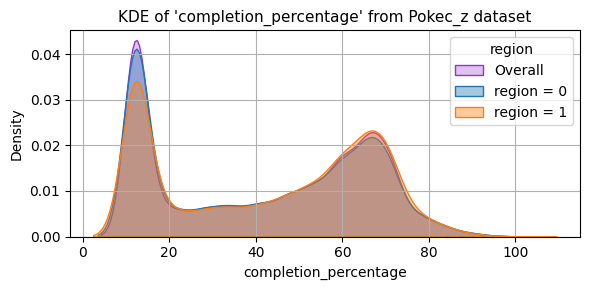

In [13]:
# 분포 시각화

# fig, axes = plt.subplots(1, 2, figsize=(12, 3))
# sns.kdeplot(data=df, x=col, ax=axes[0], fill=True, color='darkorchid')
# axes[0].set_title(f"KDE of '{col}' of {dn} dataset", size=11)
# axes[0].set_xlabel(col, size=10)
# axes[0].set_ylabel('Density', size=10)
# axes[0].grid(True)
# sns.kdeplot(data=df, x=col, hue=group, ax=axes[1], fill=True, common_norm=False, alpha=0.5)
# axes[1].set_title(f"KDE of '{col}' by {group} of {dn} dataset", size=11)
# axes[1].set_xlabel(col, size=10)
# axes[1].set_ylabel('Density', size=10)
# axes[1].grid(True)

# plt.tight_layout()
# plt.show()

plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x=col, fill=True, color='darkorchid', alpha=0.3, linewidth=1, label='Overall')
for value in sorted(df[group].unique()):
    subset = df[df[group] == value]
    sns.kdeplot(data=subset, x=col, fill=True, alpha=0.4, label=f"{group} = {value}")

plt.title(f"KDE of '{col}' from {dn} dataset", size=11)
plt.xlabel(col, size=10)
plt.ylabel('Density', size=10)
plt.legend(title=group)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# 데이터셋 로드
seed = 1127
tau = 0.9

if dataset == 'nba':
    predict_attr, sens_attr, label_number, sens_number, test_idx, path = nba_predict_attr, nba_sens_attr, nba_label_number, nba_sens_number, nba_test_idx, nba_path
elif dataset == 'german':
    predict_attr, sens_attr, path = german_predict_attr, german_sens_attr, german_path
else:
    predict_attr, sens_attr, label_number, sens_number, test_idx, path = pokec_predict_attr, pokec_sens_attr, pokec_label_number, pokec_sens_number, pokec_test_idx, pokec_path

adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset_unified(dataset, sens_attr, predict_attr, path, label_number, sens_number, test_idx, seed=seed)

if dataset == 'nba':
    features = feature_norm(features)

if isinstance(adj, torch.Tensor):  # torch.sparse_coo_tensor
    src, dst = adj._indices()
    g = dgl.graph((src, dst))
    edge_index = adj._indices()
else:  # scipy sparse matrix
    g = dgl.from_scipy(adj)
    adj_coo = adj.tocoo()
    edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

# 3. PyG-style 데이터 객체
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((features.shape[0],), tau))
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test
data.idx_sens_train = idx_sens_train

Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0


C:\Users\user\AppData\Local\Temp\ipykernel_12904\2187334796.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)


## 실험

### 실험 설정

In [31]:
# 실험 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Device:', device)

tau = 0.9
lambda_fair = 1.0
hidden_dim = 64
n_epochs = 500
n_runs = 5
lr = 0.01
weight = 5e-4

# data = data.to(device)
# data.sensitive_attr = data.sensitive_attr.to(device)

# DGL 그래프는 GPU로 올리지 않음
# g = g.to(device)

Device: cuda:0


### 간단 비교 실험

In [ ]:
# 전체 모델에 대해서 수행
all_dataset_results = {}

for dataset in ['region_job', 'region_job_2', 'nba', 'german']:
    seed = 1127
    if dataset == 'nba':
        predict_attr, sens_attr, label_number, sens_number, test_idx, path = nba_predict_attr, nba_sens_attr, nba_label_number, nba_sens_number, nba_test_idx, nba_path
    elif dataset == 'german':
        predict_attr, sens_attr, path = german_predict_attr, german_sens_attr, german_path
    else:
        predict_attr, sens_attr, label_number, sens_number, test_idx, path = pokec_predict_attr, pokec_sens_attr, pokec_label_number, pokec_sens_number, pokec_test_idx, pokec_path

    adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset_unified(dataset, sens_attr, predict_attr, path, label_number, sens_number, test_idx, seed=seed)

    if dataset == 'nba':
        features = feature_norm(features)

    if isinstance(adj, torch.Tensor):  # torch.sparse_coo_tensor
        src, dst = adj._indices()
        g = dgl.graph((src, dst))
        edge_index = adj._indices()
    else:  # scipy sparse matrix
        g = dgl.from_scipy(adj)
        adj_coo = adj.tocoo()
        edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

    data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((features.shape[0],), tau))
    data.idx_train = idx_train
    data.idx_val = idx_val
    data.idx_test = idx_test
    data.idx_sens_train = idx_sens_train

    results = []

    fair_qr, fair_fair = run_experiment(FairGNN_Q, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)
    results.append({'Model': 'FairGNN', 'QR Loss': fair_qr, 'Fairness Gap': fair_fair,})

    fmp_qr, fmp_fair = run_experiment(FMP_Q, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)
    results.append({'Model': 'FMP', 'QR Loss': fmp_qr, 'Fairness Gap': fmp_fair,})

    plain_qr, plain_fair = run_experiment(MYPlainGNN, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)
    results.append({'Model': 'B-GNN', 'QR Loss': plain_qr, 'Fairness Gap': plain_fair,})

    myfair_qr, myfair_fair = run_experiment(MYFairGNN, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)
    results.append({'Model': 'F-GNN', 'QR Loss': myfair_qr, 'Fairness Gap': myfair_fair,})

    dist_qr, dist_fair = run_experiment(DAFGNN, data, device, tau, lambda_fair, hidden_dim, n_epochs, lr, weight)
    results.append({'Model': 'DAF-GNN', 'QR Loss': dist_qr, 'Fairness Gap': dist_fair,})

    # 결과 입력
    all_dataset_results[dataset] = results

Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
cuda:0
----------------------------------------------------------------------------------------------------
[FairGNN_Q] Epoch 100: Val QR Loss=10.6781, Fairness Gap=3.0136
[FairGNN_Q] Epoch 200: Val QR Loss=9.7702, Fairness Gap=2.2615
[FairGNN_Q] Epoch 300: Val QR Loss=9.6836, Fairness Gap=2.0447
[FairGNN_Q] Epoch 400: Val QR Loss=9.5166, Fairness Gap=1.4875
[FairGNN_Q] Epoch 500: Val QR Loss=8.7837, Fairness Gap=1.4418
cuda:0
----------------------------------------------------------------------------------------------------
[FMP_Q] Epoch 100: Val QR Loss=3.7564, Fairness Gap=3.4993
[FMP_Q] Epoch 200: Val QR Loss=1.3917, Fairness Gap=2.3070
[FMP_Q] Epoch 300: Val QR Loss=0.9408, Fairness Gap=1.9572
[FMP_Q] Epoch 400: Val QR Loss=0.9054, Fairness Gap=1.8058
[FMP_Q] Epoch 500: Val QR Loss=0.9205, Fairness Gap=1.6989
cuda:0
-----------------------------------------------------------------------------

In [69]:
# 실험 결과 출력
for dataset in ['region_job', 'region_job_2', 'nba', 'german']:
    df = pd.DataFrame(all_dataset_results[dataset]).round(2)
    print(dataset)
    print(df)
    print('-' * 100)

region_job
     Model  QR Loss  Fairness Gap
0  FairGNN     8.82          1.68
1      FMP     0.94          1.88
2    B-GNN     4.69          1.31
3    F-GNN     3.64          0.26
4  DAF-GNN     4.16          1.58
----------------------------------------------------------------------------------------------------
region_job_2
     Model  QR Loss  Fairness Gap
0  FairGNN     8.90          2.82
1      FMP     0.97          3.57
2    B-GNN     5.11          3.23
3    F-GNN     3.49          0.54
4  DAF-GNN     3.21          0.48
----------------------------------------------------------------------------------------------------
nba
     Model  QR Loss  Fairness Gap
0  FairGNN     1.07          0.13
1      FMP     2.34          0.07
2    B-GNN     0.57          0.28
3    F-GNN     0.56          0.05
4  DAF-GNN     0.68          0.05
----------------------------------------------------------------------------------------------------
german
     Model  QR Loss  Fairness Gap
0  FairGNN    14

### 상세 비교 실험

In [37]:
# 전체 모델에 대해서 수행
tau = 0.5
lambda_fair = 0.5
all_dataset_results = {}

for dataset in ['region_job', 'region_job_2', 'nba', 'german']:
    seed = 1127
    if dataset == 'nba':
        predict_attr, sens_attr, label_number, sens_number, test_idx, path = nba_predict_attr, nba_sens_attr, nba_label_number, nba_sens_number, nba_test_idx, nba_path
    elif dataset == 'german':
        predict_attr, sens_attr, path = german_predict_attr, german_sens_attr, german_path
    else:
        predict_attr, sens_attr, label_number, sens_number, test_idx, path = pokec_predict_attr, pokec_sens_attr, pokec_label_number, pokec_sens_number, pokec_test_idx, pokec_path

    adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset_unified(dataset, sens_attr, predict_attr, path, label_number, sens_number, test_idx, seed=seed)
    
    print("sens 0 count:", torch.sum(sens == 0).item())
    print("sens 1 count:", torch.sum(sens == 1).item())

    if dataset == 'nba':
        features = feature_norm(features)

    if isinstance(adj, torch.Tensor):  # torch.sparse_coo_tensor
        src, dst = adj._indices()
        g = dgl.graph((src, dst))
        edge_index = adj._indices()
    else:  # scipy sparse matrix
        g = dgl.from_scipy(adj)
        adj_coo = adj.tocoo()
        edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

    data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((features.shape[0],), tau))
    data.idx_train = idx_train
    data.idx_val = idx_val
    data.idx_test = idx_test
    data.idx_sens_train = idx_sens_train

    all_results = []

    fq_results, fq_all_metrics = multiple_runs_with_full_metrics(FairGNN_Q, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
    fq_results['Model'] = 'FairGNN'
    all_results.append(fq_results)

    fmp_results, fmp_all_metrics = multiple_runs_with_full_metrics(FMP_Q, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
    fmp_results['Model'] = 'FMP'
    all_results.append(fmp_results)

    plain_results, plain_all_metrics = multiple_runs_with_full_metrics(MYPlainGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
    plain_results['Model'] = 'B-GNN'
    all_results.append(plain_results)

    fair_results, fair_all_metrics = multiple_runs_with_full_metrics(MYFairGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
    fair_results['Model'] = 'F-GNN'
    all_results.append(fair_results)

    dist_results, dist_all_metrics = multiple_runs_with_full_metrics(DAFGNN_2, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
    dist_results['Model'] = 'DAF-GNN-2'
    all_results.append(dist_results)

    dist_results, dist_all_metrics = multiple_runs_with_full_metrics(DAFGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
    dist_results['Model'] = 'DAF-GNN'
    all_results.append(dist_results)

    # 결과 입력
    all_dataset_results[dataset] = all_results
    

Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
sens 0 count: 43962
sens 1 count: 23834
----------------------------------------------------------------------------------------------------

 [FairGNN_Q] --- Run 1/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 21.3512
[Epoch 100] Loss: 11.1862
[Epoch 200] Loss: 9.6813
[Epoch 300] Loss: 8.0757
[Epoch 400] Loss: 7.3618
[Epoch 500] Loss: 6.9662

 [FairGNN_Q] --- Run 2/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 21.6733
[Epoch 100] Loss: 10.1462
[Epoch 200] Loss: 10.6282
[Epoch 300] Loss: 9.9922
[Epoch 400] Loss: 10.2252
[Epoch 500] Loss: 8.8750

 [FairGNN_Q] --- Run 3/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 21.6660
[Epoch 100] Loss: 9.2867
[Epoch 200] Loss: 8.9342
[

In [39]:
# 실험 결과 출력
for dataset in ['region_job', 'region_job_2', 'nba', 'german']:
    df = pd.DataFrame(all_dataset_results[dataset]).round(2)
    print('-' * 100)
    print(dataset)
    print('-' * 100)

    # 정확도(예측 성능) 관련 지표 # 불확실성(분산, 안정성) 관련 지표
    # df_1 = df[['Model', 
    #                     'QR Loss Mean', 'QR Loss Std', 
    #                     'MAE Mean', 'MAE Std', 
    #                     'MAPE Mean', 'MAPE Std', 
    #                     'RMSE Mean', 'RMSE Std', 
    #                     'R2 Mean', 'R2 Std',
    #                     'MAE-Var Mean', 'MAE-Var Std', 
    #                     'MAPE-Var Mean', 'MAPE-Var Std'
    #                     ]].round(2)

    # metrics = [
    #     'QR Loss', 
    #     'MAE', 
        # 'MAPE', 
        # 'RMSE', 
        # 'R2', 
    #     'MAE-Var', 'MAPE-Var']
    # latex_lines = generate_latex_rows(df_1, metrics, end_column=' & --')
    # for l in latex_lines:
    #     print(l)
    # print('-' * 100)

    # 공정성 관련 지표 # 그룹별 성능 지표
    # df_2 = df[['Model', 
    #                     'Mean Gap Mean', 'Mean Gap Std', 
    #                     'MAE Gap Mean', 'MAE Gap Std', 
    #                     'RMSE Gap Mean', 'RMSE Gap Std', 
    #                     'Error-Sensitive Corr Mean', 'Error-Sensitive Corr Std', 
    #                     'mean_group_0 Mean', 'mean_group_0 Std',
    #                     'mae_group_0 Mean', 'mae_group_0 Std', 
    #                     'rmse_group_0 Mean', 'rmse_group_0 Std', 
    #                     'mean_group_1 Mean', 'mean_group_1 Std',
    #                     'mae_group_1 Mean', 'mae_group_1 Std', 
    #                     'rmse_group_1 Mean', 'rmse_group_1 Std']].round(2)

    # metrics = [
            #     'mean_group_0', 'mean_group_1', 
            #    'mae_group_0', 'mae_group_1', 
            #    'rmse_group_0', 'rmse_group_1', 
    #            'Mean Gap', 
    #            'MAE Gap', 
    #            'RMSE Gap', 
    #            'Error-Sensitive Corr'
    #            ]
    # latex_lines = generate_latex_rows(df_2, metrics, end_column='')
    # for l in latex_lines:
    #     print(l)

    # 수정된 메트릭스 추출
    metrics = [
        'QR Loss', 'MAE',
         # 'RMSE', 
        'Mean Gap', 
        # 'MAE Gap', 
        # 'Error-Sensitive Corr',
        'MAE-Var'
        # , 'MAPE-Var'
        ]
    latex_lines = generate_latex_rows(df, metrics, end_column='')
    for l in latex_lines:
        print(l)

    print('-' * 100)

----------------------------------------------------------------------------------------------------
region_job
----------------------------------------------------------------------------------------------------
& FairGNN & $8.86 \pm 0.58$ & $17.72 \pm 1.16$ & $1.34 \pm 0.67$ & $187.21 \pm 30.91$  \\
& FMP & $1.67 \pm 0.19$ & $3.35 \pm 0.37$ & $1.80 \pm 0.08$ & $14.53 \pm 2.68$  \\
& B-GNN & $8.54 \pm 0.17$ & $17.09 \pm 0.34$ & $2.37 \pm 0.11$ & $223.94 \pm 17.16$  \\
& F-GNN & $8.41 \pm 0.07$ & $16.83 \pm 0.13$ & $0.17 \pm 0.13$ & $204.66 \pm 6.59$  \\
& DAF-GNN-2 & $10.64 \pm 0.28$ & $21.28 \pm 0.57$ & $0.13 \pm 0.10$ & $301.50 \pm 21.44$  \\
& DAF-GNN & $8.60 \pm 0.07$ & $17.20 \pm 0.13$ & $1.37 \pm 0.08$ & $157.97 \pm 9.18$  \\
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
region_job_2
------------------------------------------

In [ ]:
# 시각화
models = [
    # 'FairGNN', 
    'FMP', 'B-GNN', 'F-GNN', 'DAF-GNN', 'DAF-GNN-2'
    ]
colors = sns.color_palette("muted")
datasets = list(all_dataset_results.keys())

qr_means_raw = [model_result['QR Loss Mean'] for results in all_dataset_results.values() for model_result in results]
qr_stds_raw = [model_result['QR Loss Std'] for results in all_dataset_results.values() for model_result in results]
fair_means_raw = [model_result['Mean Gap Mean'] for results in all_dataset_results.values() for model_result in results]
fair_stds_raw = [model_result['Mean Gap Std'] for results in all_dataset_results.values() for model_result in results]
mae_means_raw = [model_result['MAE Mean'] for results in all_dataset_results.values() for model_result in results]
mae_stds_raw = [model_result['MAE Std'] for results in all_dataset_results.values() for model_result in results]
mae_var_means_raw = [model_result['MAE-Var Mean'] for results in all_dataset_results.values() for model_result in results]
mae_var_stds_raw = [model_result['MAE-Var Std'] for results in all_dataset_results.values() for model_result in results]

qr_means = [np.mean(qr_means_raw[i::5]) for i in range(5)]
qr_stds = [np.mean(qr_stds_raw[i::5]) for i in range(5)]
fair_means = [np.mean(fair_means_raw[i::5]) for i in range(5)]
fair_stds = [np.mean(fair_stds_raw[i::5]) for i in range(5)]
mae_means = [np.mean(mae_means_raw[i::5]) for i in range(5)]
mae_stds = [np.mean(mae_stds_raw[i::5]) for i in range(5)]
mae_var_means = [np.mean(mae_var_means_raw[i::5]) for i in range(5)]
mae_var_stds = [np.mean(mae_var_stds_raw[i::5]) for i in range(5)]

qr_gap = np.round(np.max(qr_means) - np.min(qr_means), 3)
fair_gap = np.round(np.max(fair_means) - np.min(fair_means), 3)
width = 0.2  

# fig, ax1 = plt.subplots(figsize=(8, 3))  # 약간 넓은 plot 사이즈
# bars1 = ax1.bar(x - 1.5 * width, qr_means, width, yerr=qr_stds, capsize=5, label='QR Loss')
# bars2 = ax1.bar(x - 0.5 * width, mae_means, width, yerr=mae_stds, capsize=5, label='MAE')
# bars3 = ax1.bar(x + 0.5 * width, mae_var_means, width, yerr=mae_var_stds, capsize=5, label='MAE-var')
# bars4 = ax1.bar(x + 1.5 * width, fair_means, width, yerr=fair_stds, capsize=5, label='Fairness (Mean Gap)')

# for bar in bars1:
#     height = bar.get_height()
#     ax1.annotate(f'{height:.2f}',
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(12, 3),  # 위로 3pt
#                  textcoords="offset points",
#                  ha='center', va='bottom', fontsize=8)

# for bar in bars4:
#     height = bar.get_height()
#     ax1.annotate(f'{height:.2f}',
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(12, 3),
#                  textcoords="offset points",
#                  ha='center', va='bottom', fontsize=8)

# ax1.set_ylabel('Score')
# ax1.set_xticks(x)
# ax1.set_xticklabels(models)
# ax1.legend(loc='best', fontsize=9)
# ax1.set_title('Performance and Fairness Comparison', size=11)
# plt.tight_layout()
# plt.show()

fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # 1행 4열, 약간 더 넓게
axs[0].bar(x, qr_means, yerr=qr_stds, capsize=5, color='tab:blue')
axs[0].set_title('QR Loss')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=45, ha='right')

axs[1].bar(x, mae_means, yerr=mae_stds, capsize=5, color='tab:orange')
axs[1].set_title('MAE')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=45, ha='right')

axs[2].bar(x, mae_var_means, yerr=mae_var_stds, capsize=5, color='tab:green')
axs[2].set_title('MAE-var')
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=45, ha='right')

axs[3].bar(x, fair_means, yerr=fair_stds, capsize=5, color='tab:red')
axs[3].set_title('Fairness (Mean Gap)')
axs[3].set_xticks(x)
axs[3].set_xticklabels(models, rotation=45, ha='right')

# fig.suptitle('Performance and Fairness Comparison', fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # title 공간 확보
plt.show()

plt.figure(figsize=(6, 3))
idx = 0
for dataset in datasets:
    results = all_dataset_results[dataset]
    for i, model in enumerate(models):
        plt.scatter(
            fair_means_raw[idx], qr_means_raw[idx],
            color=colors[i], s=100, alpha=0.7, label=model
        )
        idx += 1

plt.xlabel('Fairness (Mean Gap)')
plt.ylabel('QR Loss')
plt.title('Performance-Fairness Trade-off across Datasets', size=11)
plt.grid(True)
plt.tight_layout()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict()
for handle, label in zip(handles, labels):
    if label not in by_label:
        by_label[label] = handle
plt.legend(by_label.values(), by_label.keys(), loc='lower right', frameon=True, fontsize=9)

plt.show()


In [ ]:
# 데이터셋 하나에 대해서 수행
all_results = []

fq_results, fq_all_metrics = multiple_runs_with_full_metrics(FairGNN_Q, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
fq_results['Model'] = 'FairGNN'
all_results.append(fq_results)

fmp_results, fmp_all_metrics = multiple_runs_with_full_metrics(FMP_Q, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
fmp_results['Model'] = 'FMP'
all_results.append(fmp_results)

plain_results, plain_all_metrics = multiple_runs_with_full_metrics(MYPlainGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
plain_results['Model'] = 'B-GNN'
all_results.append(plain_results)

fair_results, fair_all_metrics = multiple_runs_with_full_metrics(MYFairGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
fair_results['Model'] = 'F-GNN'
all_results.append(fair_results)

dist_results, dist_all_metrics = multiple_runs_with_full_metrics(DAFGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
dist_results['Model'] = 'DAF-GNN'
all_results.append(dist_results)

In [ ]:
# 비교 실험 결과
all_results = pd.DataFrame(all_results)
all_results.round(2)

# 정확도(예측 성능) 관련 지표 # 불확실성(분산, 안정성) 관련 지표
df_1 = all_results[['Model', 'QR Loss Mean', 'QR Loss Std', 'MAE Mean', 'MAE Std', 'MAPE Mean', 'MAPE Std', 'RMSE Mean', 'RMSE Std', 'MAE-Var Mean', 'MAE-Var Std', 'MAPE-Var Mean', 'MAPE-Var Std']].round(2)

metrics = ['QR Loss', 'MAE', 'MAPE', 'RMSE', 'MAE-Var', 'MAPE-Var']
latex_lines = generate_latex_rows(df_1, metrics, end_column=' & --')
for l in latex_lines:
    print(l)

# 공정성 관련 지표 # 그룹별 성능 지표
df_2 = all_results[['Model', 'MAE Gap (group 0 vs 1) Mean', 'MAE Gap (group 0 vs 1) Std', 'RMSE Gap (group 0 vs 1) Mean', 'RMSE Gap (group 0 vs 1) Std', 'Error-Sensitive Corr Mean', 'Error-Sensitive Corr Std', 'mae_group_0 Mean', 'mae_group_0 Std', 'rmse_group_0 Mean', 'rmse_group_0 Std', 'mae_group_1 Mean', 'mae_group_1 Std', 'rmse_group_1 Mean', 'rmse_group_1 Std']].round(2)

metrics = ['mae_group_0', 'mae_group_1', 'rmse_group_0', 'rmse_group_1', 'MAE Gap (group 0 vs 1)', 'RMSE Gap (group 0 vs 1)', 'Error-Sensitive Corr']
latex_lines = generate_latex_rows(df_2, metrics, end_column='')
for l in latex_lines:
    print(l)

In [ ]:
# 시각화
models = ['B-GNN', 'F-GNN', 'FairGNN', 'FMP', 'DAF-GNN']
colors = sns.set_palette("muted")

qr_means = all_results['QR Loss Mean']
qr_stds = all_results['QR Loss Std']
fair_means = all_results['Fairness Gap Mean']
fair_stds = all_results['Fairness Gap Std']
qr_gap = np.round(np.max(qr_means) - np.min(qr_means), 3)
fair_gap = np.round(np.max(fair_means) - np.min(fair_means), 3)

x = np.arange(len(models))
width = 0.35
fig, ax1 = plt.subplots(figsize=(6,3))
ax1.bar(x - width/2, qr_means, width, yerr=qr_stds, capsize=5, label='QR Loss')
ax1.bar(x + width/2, fair_means, width, yerr=fair_stds, capsize=5, label='Fairness Gap')
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='best')
ax1.set_title('Performance and Fairness Comparison')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
for i in range(len(models)):
    plt.scatter(fair_means[i], qr_means[i], color=colors[i], label=models[i], s=100, alpha=0.5)
for i in range(len(models)):
    plt.text(fair_means[i], qr_means[i], models[i], fontsize=11)

plt.ylabel('QR Loss')
plt.xlabel('Fair Loss')
plt.ylim(0, 11)
plt.xlim(0, 10)
# plt.xlim(right = np.max(fair_means) + fair_gap/10)
plt.title('Trade-off between Performance and Fairness')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Our 단일 실험

In [ ]:
# Our
class DAFGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, device, lambda_fair=1.0, gamma=1.0, alpha=1.0, use_projection=True, use_fairness=True):
        
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

        self.lambda_fair = lambda_fair
        self.alpha = alpha
        self.gamma = gamma
        
        self.use_projection = use_projection
        self.use_fairness = use_fairness
        
        self.device = device
        
    def forward(self, x, edge_index, return_hidden=False):
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        
        preds = self.fc(h).squeeze(-1)

        if return_hidden:
            return preds, h
        else:
            return preds
        
    def distribution_aware_fairness_loss(self, preds, sensitive, var_gap=True):
        g0 = preds[sensitive == 0]
        g1 = preds[sensitive == 1]

        if len(g0) == 0 or len(g1) == 0:
            return torch.tensor(0.0, device=preds.device)

        mean_gap = torch.abs(g0.mean() - g1.mean())
        gap = mean_gap
        
        if var_gap:
            var_gap = torch.abs(g0.var(unbiased=False) - g1.var(unbiased=False))
            gap = mean_gap + self.alpha * var_gap
        return gap

    def compute_bias_score(self, hidden, sensitive):
        g0 = hidden[sensitive == 0]
        g1 = hidden[sensitive == 1]
        bias = torch.norm(g0.mean(dim=0) - g1.mean(dim=0), p=2)
        return bias

    def adaptive_projection(self, h, bias_score):
        h_norm = h.norm(p=2, dim=1, keepdim=True) + 1e-6
        adaptive_lambda = self.lambda_fair * (1 + self.gamma * bias_score)
        scale = torch.min(torch.ones_like(h_norm), adaptive_lambda.unsqueeze(-1) / h_norm)
        return h * scale

    def hierarchical_lambda(self, epoch, max_lambda=1.0, beta=0.05):
        device = next(self.parameters()).device  # 모델 파라미터의 디바이스 확인
        return max_lambda * (1 - torch.exp(-beta * torch.tensor(epoch, dtype=torch.float32, device=device)))

    def total_loss(self, preds, hidden, sensitive, y_true, epoch, tau=0.9):
        
        loss_qr = quantile_loss(y_true, preds, tau)
        
        # Projection
        if self.use_projection:
            bias_score = self.compute_bias_score(hidden, sensitive)
            hidden = self.adaptive_projection(hidden, bias_score)
        
        # Fairness
        if self.use_fairness:
            fair_loss = self.distribution_aware_fairness_loss(preds, sensitive)  
        else:
            fair_loss =  torch.tensor(0.0, device=preds.device)

        lambda_fair = self.hierarchical_lambda(epoch, max_lambda=self.lambda_fair)

        return loss_qr + lambda_fair * fair_loss

In [ ]:
lambda_fair = 0.5
all_dataset_results = {}

for dataset in ['region_job', 'region_job_2', 'nba', 'german']:
    seed = 1127
    if dataset == 'nba':
        predict_attr, sens_attr, label_number, sens_number, test_idx, path = nba_predict_attr, nba_sens_attr, nba_label_number, nba_sens_number, nba_test_idx, nba_path
    elif dataset == 'german':
        predict_attr, sens_attr, path = german_predict_attr, german_sens_attr, german_path
    else:
        predict_attr, sens_attr, label_number, sens_number, test_idx, path = pokec_predict_attr, pokec_sens_attr, pokec_label_number, pokec_sens_number, pokec_test_idx, pokec_path

    adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset_unified(dataset, sens_attr, predict_attr, path, label_number, sens_number, test_idx, seed=seed)

    if dataset == 'nba':
        features = feature_norm(features)

    if isinstance(adj, torch.Tensor):  # torch.sparse_coo_tensor
        src, dst = adj._indices()
        g = dgl.graph((src, dst))
        edge_index = adj._indices()
    else:  # scipy sparse matrix
        g = dgl.from_scipy(adj)
        adj_coo = adj.tocoo()
        edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

    data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((num_nodes,), tau))
    data.idx_train = idx_train
    data.idx_val = idx_val
    data.idx_test = idx_test
    data.idx_sens_train = idx_sens_train

    all_results = []

    dist_results, dist_all_metrics = multiple_runs_with_full_metrics(DAFGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair, reg=True)
    # dist_results['Model'] = 'DAF-GNN'
    all_results.append(dist_results)

    # 결과 입력
    all_dataset_results[dataset] = all_results    

In [ ]:
qr_means_raw = [model_result['QR Loss Mean'] for results in all_dataset_results.values() for model_result in results]
qr_stds_raw = [model_result['QR Loss Std'] for results in all_dataset_results.values() for model_result in results]
fair_means_raw = [model_result['Mean Gap Mean'] for results in all_dataset_results.values() for model_result in results]
fair_stds_raw = [model_result['Mean Gap Std'] for results in all_dataset_results.values() for model_result in results]
mae_means_raw = [model_result['MAE Mean'] for results in all_dataset_results.values() for model_result in results]
mae_stds_raw = [model_result['MAE Std'] for results in all_dataset_results.values() for model_result in results]
mae_var_means_raw = [model_result['MAE-Var Mean'] for results in all_dataset_results.values() for model_result in results]
mae_var_stds_raw = [model_result['MAE-Var Std'] for results in all_dataset_results.values() for model_result in results]

qr_means = [np.mean(qr_means_raw[i::5]) for i in range(5)]
qr_stds = [np.mean(qr_stds_raw[i::5]) for i in range(5)]
fair_means = [np.mean(fair_means_raw[i::5]) for i in range(5)]
fair_stds = [np.mean(fair_stds_raw[i::5]) for i in range(5)]
mae_means = [np.mean(mae_means_raw[i::5]) for i in range(5)]
mae_stds = [np.mean(mae_stds_raw[i::5]) for i in range(5)]
mae_var_means = [np.mean(mae_var_means_raw[i::5]) for i in range(5)]
mae_var_stds = [np.mean(mae_var_stds_raw[i::5]) for i in range(5)]

qr_gap = np.round(np.max(qr_means) - np.min(qr_means), 3)
fair_gap = np.round(np.max(fair_means) - np.min(fair_means), 3)

### 추가 실험

#### lambda 실험

In [104]:
# lambda_fair Trade-off 실험
lambdas = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
results = []

for lambda_fair in lambdas:
    print(f"\n=== Lambda {lambda_fair} ===")
    fair_results, _ = multiple_runs_with_full_metrics(DistributionAwareFairGNN, data, device, n_runs, hidden_dim, n_epochs, tau, lambda_fair)

    fair_results['Lambda'] = lambda_fair
    results.append(fair_results)


=== Lambda 0.0 ===
----------------------------------------------------------------------------------------------------

 [DistributionAwareFairGNN] --- Run 1/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 7.6071
[Epoch 100] Loss: 0.8239
[Epoch 200] Loss: 0.8123
[Epoch 300] Loss: 0.7989
[Epoch 400] Loss: 0.7734
[Epoch 500] Loss: 0.7184

 [DistributionAwareFairGNN] --- Run 2/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 25.9505
[Epoch 100] Loss: 0.8263
[Epoch 200] Loss: 0.8060
[Epoch 300] Loss: 0.7888
[Epoch 400] Loss: 0.7265
[Epoch 500] Loss: 0.7776

 [DistributionAwareFairGNN] --- Run 3/5 ---
----------------------------------------------------------------------------------------------------
[Epoch 1] Loss: 10.9024
[Epoch 100] Loss: 0.8252
[Epoch 200] Loss: 0.8108
[Epoch 300] Loss: 0.7871
[Epoch 400] Loss: 0.7388
[Epoch 500] Loss: 0.

In [108]:
df_lambda = pd.DataFrame(results)
df_lambda.round(4)

,QR Loss Mean,QR Loss Std,MAE Mean,MAE Std,RMSE Mean,RMSE Std,R2 Mean,R2 Std,Fairness Gap Mean,Fairness Gap Std,Lambda
0,0.6398,0.0300,5.0347,1.0447,5.9431,1.0952,-2.2302,1.0297,0.7486,0.0783,0.00
1,0.6177,0.0369,4.8036,0.9577,5.6771,0.9710,-1.9341,0.9896,0.6464,0.0794,0.01
2,0.6471,0.1212,5.6536,1.4627,6.4156,1.4446,-2.8251,1.9108,0.4309,0.1394,0.05
3,0.5897,0.0279,4.5419,0.5585,5.3314,0.6264,-1.5488,0.5855,0.2008,0.1480,0.10
4,0.6132,0.0221,4.6082,0.6055,5.4219,0.6064,-1.6327,0.5944,0.0564,0.0295,0.50
5,0.6652,0.0372,5.2318,0.9125,6.0888,0.9047,-2.3515,0.9695,0.1166,0.0790,1.00
6,0.6584,0.0141,5.2408,0.3457,6.1462,0.3360,-2.3513,0.3651,0.1804,0.0267,5.00
7,0.6399,0.0165,4.9940,0.5115,5.8484,0.5442,-2.0516,0.5335,0.1825,0.0573,10.00


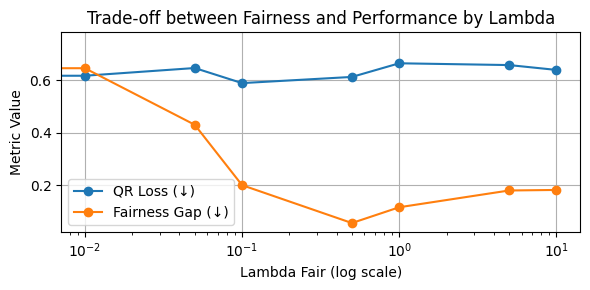

In [109]:
# 시각화
plt.figure(figsize=(6,3))
plt.plot(df_lambda['Lambda'], df_lambda['QR Loss Mean'], marker='o', label='QR Loss (↓)')
plt.plot(df_lambda['Lambda'], df_lambda['Fairness Gap Mean'], marker='o', label='Fairness Gap (↓)')
plt.xscale('log')  # λ는 보통 로그스케일로 표현
plt.xlabel('Lambda Fair (log scale)')
plt.ylabel('Metric Value')
plt.title('Trade-off between Fairness and Performance by Lambda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Ablation 실험

In [162]:
# Ablation study
lambda_fair = 0.5
all_dataset_results = {}

for dataset in ['region_job', 'region_job_2', 'nba', 'german']:
    seed = 1127
    if dataset == 'nba':
        predict_attr, sens_attr, label_number, sens_number, test_idx, path = nba_predict_attr, nba_sens_attr, nba_label_number, nba_sens_number, nba_test_idx, nba_path
    elif dataset == 'german':
        predict_attr, sens_attr, path = german_predict_attr, german_sens_attr, german_path
    else:
        predict_attr, sens_attr, label_number, sens_number, test_idx, path = pokec_predict_attr, pokec_sens_attr, pokec_label_number, pokec_sens_number, pokec_test_idx, pokec_path

    adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset_unified(dataset, sens_attr, predict_attr, path, label_number, sens_number, test_idx, seed=seed)

    if dataset == 'nba':
        features = feature_norm(features)

    if isinstance(adj, torch.Tensor):  # torch.sparse_coo_tensor
        src, dst = adj._indices()
        g = dgl.graph((src, dst))
        edge_index = adj._indices()
    else:  # scipy sparse matrix
        g = dgl.from_scipy(adj)
        adj_coo = adj.tocoo()
        edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

    data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens)
    data.idx_train = idx_train
    data.idx_val = idx_val
    data.idx_test = idx_test
    data.idx_sens_train = idx_sens_train

    all_results = []
    
    print('-' * 100)
    print(dataset)
    print('-' * 100)
    
    df_ablation = run_ablation_experiments(data, device, lambda_fair, n_runs)
    print('-' * 100)

    all_dataset_results[dataset] = df_ablation 

Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
----------------------------------------------------------------------------------------------------
region_job
----------------------------------------------------------------------------------------------------

[Full] Run 1/5
[Epoch 1] Loss: 38.7758
[Epoch 100] Loss: 8.4558
[Epoch 200] Loss: 6.4128
[Epoch 300] Loss: 6.4133
[Epoch 400] Loss: 4.8929
[Epoch 500] Loss: 4.5515

[Full] Run 2/5
[Epoch 1] Loss: 38.8719
[Epoch 100] Loss: 7.9785
[Epoch 200] Loss: 5.2511
[Epoch 300] Loss: 6.5498
[Epoch 400] Loss: 5.5234
[Epoch 500] Loss: 4.2117

[Full] Run 3/5
[Epoch 1] Loss: 39.1599
[Epoch 100] Loss: 6.2895
[Epoch 200] Loss: 7.1458
[Epoch 300] Loss: 5.5243
[Epoch 400] Loss: 4.6411
[Epoch 500] Loss: 4.1230

[Full] Run 4/5
[Epoch 1] Loss: 39.1481
[Epoch 100] Loss: 6.8560
[Epoch 200] Loss: 5.3702
[Epoch 300] Loss: 5.9302
[Epoch 400] Loss: 4.6596
[Epoch 500] Loss: 5.4981

[Full] Run 5/5
[Epoch 1] Loss: 39.032

In [163]:
for dataset in ['region_job', 'region_job_2', 'nba', 'german']:
    print(all_dataset_results[dataset][['Setting', 'QR Loss Mean', 'Fairness Gap Mean']].round(2))
    print('-' * 50)

                    Setting  QR Loss Mean  Fairness Gap Mean
0                      Full          3.95               1.84
1            w/o Projection          3.90               1.74
2              w/o Fairness          4.45               1.33
3                w/o Lambda          3.85               1.63
4  w/o Projection, Fairness          4.62               1.19
5    w/o Projection, Lambda          3.77               1.58
6      w/o Fairness, Lambda          4.60               0.94
7                   w/o All          4.59               1.14
--------------------------------------------------
                    Setting  QR Loss Mean  Fairness Gap Mean
0                      Full          3.29               0.69
1            w/o Projection          3.29               0.67
2              w/o Fairness          4.73               3.53
3                w/o Lambda          3.35               0.61
4  w/o Projection, Fairness          4.74               3.70
5    w/o Projection, Lambda       

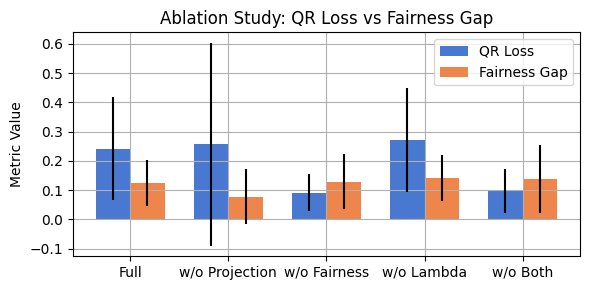

In [154]:
# 시각화
x = np.arange(len(df_ablation))
width = 0.35
fig, ax1 = plt.subplots(figsize=(6,3))
ax1.bar(x - width/2, df_ablation['QR Loss Mean'], width, yerr=df_ablation['QR Loss Std'], label='QR Loss')
ax1.bar(x + width/2, df_ablation['Fairness Gap Mean'], width, yerr=df_ablation['Fairness Gap Std'], label='Fairness Gap')
ax1.set_ylabel('Metric Value')
ax1.set_title('Ablation Study: QR Loss vs Fairness Gap')
ax1.set_xticks(x)
ax1.set_xticklabels(df_ablation['Setting'])
ax1.legend()
ax1.grid(True)
plt.tight_layout()
plt.show()